In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import math
import gdown
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTENC
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
import pickle
import time
from datetime import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

2023-06-06 16:36:49.174821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part I Data Cleaning

# Part II DID Model

#### Data

In [2]:
# Ads
url ='https://drive.google.com/file/d/1Q_IC0JBoZpT0DfOBNq98gc_IwyOXtfIP/view?usp=share_link'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'Ads.csv'
gdown.download(url, file, quiet = False)
Ads = pd.read_csv(file)
'''Ads = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Ads.csv')
Ads['date'] = pd.to_datetime(Ads['date'])'''

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Q_IC0JBoZpT0DfOBNq98gc_IwyOXtfIP
From (redirected): https://drive.google.com/uc?id=1Q_IC0JBoZpT0DfOBNq98gc_IwyOXtfIP&confirm=t&uuid=724df50b-7111-40e3-a4f8-9375a05634c7
To: /Users/haroldisthebest/Desktop/Ads.csv
100%|██████████| 394M/394M [00:10<00:00, 37.2MB/s] 


"Ads = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Ads.csv')\nAds['date'] = pd.to_datetime(Ads['date'])"

In [3]:
# Sales
url ='https://drive.google.com/file/d/1ah2kkUn5tPZAHoCaOrwdeUWuoU4SowD8/view?usp=share_link'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file_Sales = 'Sales.csv'
gdown.download(url, file, quiet = False)
Sales = pd.read_csv(file)
'''Sales = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Sales.csv')
Sales['date'] = pd.to_datetime(Sales['date'])
Sales = Sales[Sales['date'] <= '2023-01-07']'''

Downloading...
From (uriginal): https://drive.google.com/uc?id=1ah2kkUn5tPZAHoCaOrwdeUWuoU4SowD8
From (redirected): https://drive.google.com/uc?id=1ah2kkUn5tPZAHoCaOrwdeUWuoU4SowD8&confirm=t&uuid=24f1ffa3-758b-4a4f-b17d-c3d200293686
To: /Users/haroldisthebest/Desktop/Ads.csv
100%|██████████| 892M/892M [00:23<00:00, 37.9MB/s] 


"Sales = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Sales.csv')\nSales['date'] = pd.to_datetime(Sales['date'])\nSales = Sales[Sales['date'] <= '2023-01-07']"

## 0 Preparation

In [4]:
Ads_gb_asin = Ads.groupby('asin')
Sales_gb_asin = Sales.groupby('asin')

### 0.1 Check how many products have ads

In [5]:
# Count number of unique asins in each dataset 
# The number of products that have been advertised: 2368
Ads_asin = Ads['asin'].unique()
# The number of products that have sales records: 59312
Sales_asin = Sales['asin'].unique()
# The number of products that don't have ads records at all: 56945
Noads_asin = list(set(Sales_asin) - set(Ads_asin)) 

### 0.2 Price

#### a. Price Method 1

In [6]:
# Assuming that the price of each product remains constant
# calculate the price of each product by dividing the total sales revenue by the total number of units sold
Price1 = Sales_gb_asin[['total_rev', 'units_total']].sum()
Price1['unit_price'] = round(Price1['total_rev'] / Price1['units_total'])

#### b. Price Method 2

In [7]:
# Assuming that the price of the product changes
# calculate the price of the product on a given day by dividing the total sales revenue for that day by the total sales volume for that day
# use forward or backward fill to fill the missing values
Price2 = Sales[['asin', 'date', 'total_rev', 'units_total']].sort_values(by = ['asin', 'date'], ascending = True)
Price2['price'] = Price2['total_rev'] / Price2['units_total']

In [8]:
Price2_group = Price2.groupby('asin')
Price2['price'] = Price2_group['price'].fillna(method = 'ffill')
Price2['price'] = Price2_group['price'].fillna(method = 'bfill')

### 0.3 Impression

In [9]:
# Table shows the daily ad traffic and the number of keywords each product advertised on for each day
asin_impression = Ads.groupby(['asin', 'date']).agg({'impressions': 'sum', 'keyword': 'nunique'})
asin_impression = asin_impression.rename(columns = {'keyword': 'ads_num'})

In [10]:
asin_impression

impressions  ads_num
asin       date                            
B0000225HZ 2022-03-09         92.0        5
           2022-03-10        140.0        2
           2022-03-11        215.0        1
           2022-03-12         86.0        2
           2022-03-13         90.0        1
...                            ...      ...
B0BM4YSSNY 2023-01-03          9.0        1
           2023-01-05        164.0        1
           2023-01-06         88.0        1
           2023-01-07        137.0        1
B0BMF8YH2P 2022-12-17          2.0        1

[296638 rows x 2 columns]

### 0.4 Sales Days

In [11]:
# Count the number of days each product has sales records. 
# Since sales records are available from 2022-01-02 to 2023-01-07, the number of days for a product with continuous sales should be 374
Sales_SandE = Sales_gb_asin['date'].count().to_frame().rename(columns = {'date':'S_delta'})
Sales_SandE = pd.merge(Sales_gb_asin['date'].agg(['min', 'max']), Sales_SandE, left_index = True, right_index = True)
Sales_SandE = Sales_SandE.rename(columns = {'min': 'S_first_date', 'max':'S_last_date'})
Sales_SandE.head()

,S_first_date,S_last_date,S_delta
asin,,,
099051000X,2022-01-02,2023-01-10,374
B00002240O,2022-07-04,2023-01-10,191
B00002240P,2022-07-01,2023-01-10,194
B0000225HZ,2022-01-02,2023-01-10,374
B0000225IB,2022-01-02,2023-01-10,374


### 0.5 Ads Days
- The first and the last advertised date for each product
- Ads_delta & actual ads days

In [12]:
# Aggregate each day's advertising data for each asin
Ads_agg = Ads.groupby(['asin', 'date'])[['impressions', 'click', 'conversions']].sum().reset_index()
Ads_agg = pd.merge(Ads_agg, asin_impression[['ads_num']].reset_index(), on=['asin', 'date'], how='left' )
# Combine sales and advertising data by asin and date(how = 'right' => based on Sales)
Sales_selected = Sales.loc[Sales['asin'].isin(Ads_asin), ['asin', 'date', 'total_rev', 'units_total', 'attr_rev', 'attr_units']]
Ads_agg = pd.merge(Ads_agg, Sales_selected, on = ['asin', 'date'], how = 'right').set_index(['asin', 'date']).sort_index()
# If a record appears only in the sales dataset, it indicates that the item was not advertised on that day('ads' = 0)
# If it appears in both data tables, it means that the item was advertised that day ('ads' = 1)
Ads_agg['ads'] = np.where(pd.isna(Ads_agg['click']), 0, 1)

In [13]:
Ads_agg.head()

impressions  click  conversions  ads_num  total_rev  \
asin       date                                                              
B0000225HZ 2022-01-02          NaN    NaN          NaN      NaN      56.99   
           2022-01-03          NaN    NaN          NaN      NaN     170.97   
           2022-01-04          NaN    NaN          NaN      NaN       0.00   
           2022-01-05          NaN    NaN          NaN      NaN       0.00   
           2022-01-06          NaN    NaN          NaN      NaN      56.99   

                       units_total  attr_rev  attr_units  ads  
asin       date                                                
B0000225HZ 2022-01-02            1       0.0         0.0    0  
           2022-01-03            3       0.0         0.0    0  
           2022-01-04            0       0.0         0.0    0  
           2022-01-05            0       0.0         0.0    0  
           2022-01-06            1       0.0         0.0    0

#### a. Ads Days

In [14]:
Actual_Ads_Days = Ads_agg[Ads_agg['ads'] == 1].groupby('asin').size().rename('A_actual')

#### b. Ads Delta

In [15]:
def find_first_and_last_date(group):
    ads_dates = group[group['ads'] == 1]['date']
    if len(ads_dates) == 0:
        return pd.Series({'A_first_date': None, 'A_last_date': None})
    else:
        first_date = pd.to_datetime(ads_dates.min(), unit='ns').date()
        last_date = pd.to_datetime(ads_dates.max(), unit='ns').date()
        return pd.Series({'A_first_date': first_date, 'A_last_date': last_date})

In [16]:
Ads_SandE = Ads_agg.reset_index().groupby('asin').apply(find_first_and_last_date)
Ads_SandE['A_last_date'] = pd.to_datetime(Ads_SandE['A_last_date'])
Ads_SandE['A_first_date'] = pd.to_datetime(Ads_SandE['A_first_date']) 
Ads_SandE['A_delta'] = (Ads_SandE['A_last_date'] - Ads_SandE['A_first_date']).dt.days + 1
Ads_SandE = Ads_SandE.dropna()
Ads_SandE['A_delta'] = Ads_SandE['A_delta'].astype(int)

In [17]:
Ads_SandE.head()

,A_first_date,A_last_date,A_delta
asin,,,
B0000225HZ,2022-03-09,2022-12-08,275
B0000225IB,2022-08-08,2022-11-02,87
B00006RGKR,2022-01-02,2022-08-26,237
B0000A1WGL,2022-01-02,2022-12-25,358
B0000AQO11,2022-11-29,2023-01-07,40


## 2 Classical DID
---
Super undisciplined ！！！

### 2.1 Preparation

In [18]:
SandA_Info = pd.merge(Sales_SandE, Ads_SandE, left_index = True, right_index = True)
SandA_Info = SandA_Info.merge(Actual_Ads_Days, left_index = True, right_index = True, how = 'left')
SandA_Info.head()

,S_first_date,S_last_date,S_delta,A_first_date,A_last_date,A_delta,A_actual
asin,,,,,,,
B0000225HZ,2022-01-02,2023-01-10,374,2022-03-09,2022-12-08,275,185
B0000225IB,2022-01-02,2023-01-10,374,2022-08-08,2022-11-02,87,21
B00006RGKR,2022-01-02,2023-01-10,374,2022-01-02,2022-08-26,237,100
B0000A1WGL,2022-01-02,2023-01-10,374,2022-01-02,2022-12-25,358,309
B0000AQO11,2022-11-29,2023-01-10,43,2022-11-29,2023-01-07,40,40


#### a. Control Group

- Select products which sold from 2022-01-02 to 2023-01-07 => 371 sales days
- no ads days / 371 >= 95% 

In [19]:
# 343 products
DID_Control_asin = SandA_Info[(SandA_Info['S_delta'] == 371) & 
                              ((SandA_Info['S_delta'] - SandA_Info['A_actual']) / 371 >= 0.95)].index

#### b. Treatment Group

In [20]:
SandA_Info['S_first_date'] = pd.to_datetime(SandA_Info['S_first_date'])
SandA_Info['A_first_date'] = pd.to_datetime(SandA_Info['A_first_date'])

In [21]:
DID_Treatment_asin = SandA_Info[(SandA_Info['A_actual'] / SandA_Info['A_delta'] >= 0.9) &
                                (SandA_Info['S_first_date'] <= pd.Timestamp('2022-02-01'))&
                                (SandA_Info['A_actual'] >= 180) & 
                                (SandA_Info['A_first_date'] >= pd.Timestamp('2022-02-01'))].index

In [22]:
DID_cls = Ads_agg.reset_index()
DID_cls = DID_cls[DID_cls['asin'].isin(DID_Control_asin) | DID_cls['asin'].isin(DID_Treatment_asin)]
DID_cls['date'] = pd.to_datetime(DID_cls['date'])
# Flag if in treatment group
DID_cls['treat'] = DID_cls['asin'].isin(DID_Treatment_asin).astype(int)
# 0 if before 3/15/2022 and 1 if after 3/15/2022 
DID_cls['after'] = (DID_cls['date'] >= pd.Timestamp('2022-03-15')).astype(int)
DID_cls.head()

,asin,date,impressions,click,conversions,ads_num,total_rev,units_total,attr_rev,attr_units,ads,treat,after
20909,B0002ARR2W,2022-01-02,NaN,NaN,NaN,NaN,1578.33,117,0.0,0.0,0,1,0
20910,B0002ARR2W,2022-01-03,NaN,NaN,NaN,NaN,1335.51,99,0.0,0.0,0,1,0
20911,B0002ARR2W,2022-01-04,NaN,NaN,NaN,NaN,1362.49,101,0.0,0.0,0,1,0
20912,B0002ARR2W,2022-01-05,NaN,NaN,NaN,NaN,1551.35,115,0.0,0.0,0,1,0
20913,B0002ARR2W,2022-01-06,NaN,NaN,NaN,NaN,1551.35,115,0.0,0.0,0,1,0


### 2.2 Classical DID Model

In [23]:
# Baic Model
import statsmodels.formula.api as smf
mod_did = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls).fit()
mod_did.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1072.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:38:24   Log-Likelihood:            -1.0410e+05
No. Observations:               19294   AIC:                         2.083e+05
Df Residuals:                   19240   BIC:                         2.087e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.545e+12   1.56e+12      0.988      0.323   -1.52e+12    4.61e+12
C(asin)[T.B000KYKOGG]   -82.1141      3.908    -21.014      0.000     -89.773     -74.455
C(asin)[T.B000KYMBSK]   -76.9980      3.907    -19.706      0.000     -84.657     -69.339
C(asin)[T.B000KYSDEG]   -80.9741      3.907    -20.724      0.000     -88.633     -73.316
C(asin)[T.B000L981X8]   -76.9797      3.907    -19.702      0.000     -84.638     -69.321
C(asin)[T.B000L98250]   -80.5183      3.907    -20.607      0.000     -88.177     -72.860
C(asin)[T.B000L9CBAW]   -81.8341      3.907    -20.944      0.000     -89.493     -74.176
C(asin)[T.B000L9CXGO]   -81.3470      3.917    -20.767      0.000     -89.025     -73.669
C(asin)[T.B000LNOSQI]   -80.7086      3.917    -20.606      0.000     -88.386     -73.031
C(asin)[T.B000LNQ36G]   -79.0655      3.965    -19.939      0.000     -86.838     -71.293
C(asin)[T.B000LNRHXY]   -81.5193      3.967    -20.548      0.000     -89.295     -73.743
C(asin)[T.B000LNRHYS]   -80.8910      4.065    -19.898      0.000     -88.859     -72.923
C(asin)[T.B000XO7RFY]   -81.7346      3.951    -20.689      0.000     -89.478     -73.991
C(asin)[T.B000YOPVQ0]   -79.8189      3.926    -20.332      0.000     -87.514     -72.124
C(asin)[T.B000Z597EA]   -79.2655      3.911    -20.265      0.000     -86.932     -71.599
C(asin)[T.B000Z8BB4Q]   -82.3807      3.907    -21.084      0.000     -90.039     -74.722
C(asin)[T.B000Z8F2YQ]   -81.8121      3.907    -20.939      0.000     -89.471     -74.154
C(asin)[T.B000ZN08CM]   -80.7889      3.907    -20.677      0.000     -88.447     -73.130
C(asin)[T.B000ZSGWWM]   -79.6940      3.907    -20.396      0.000     -87.353     -72.035
C(asin)[T.B001ALY8SS]   -69.3237      3.907    -17.742      0.000     -76.982     -61.665
C(asin)[T.B001MKPFW0]   -80.2312      3.912    -20.506      0.000     -87.900     -72.562
C(asin)[T.B002ATFYFK]   -81.2104      3.907    -20.784      0.000     -88.869     -73.552
C(asin)[T.B002D32H58]   -80.9147      3.907    -20.709      0.000     -88.573     -73.256
C(asin)[T.B0031X35YQ]   -74.4615      3.907    -19.057      0.000     -82.120     -66.803
C(asin)[T.B0036THLL8]   -59.3747      3.907    -15.196      0.000     -67.033     -51.716
C(asin)[T.B0036THLVI]   -72.0180      3.969    -18.146      0.000     -79.797     -64.239
C(asin)[T.B0036THLZY]   -67.7278      3.920    -17.276      0.000     -75.412     -60.043
C(asin)[T.B0036THMYE]     2.0207      3.912      0.517      0.605      -5.647       9.688
C(asin)[T.B0036THN0M]     6.8018      3.908      1.740      0.082      -0.859      14.462
C(asin)[T.B0036THN7A]   -67.5748      3.913    -17.270      0.000     -75.244     -59.905
C(asin)[T.B003PQXDGO]   -80.9167      3.914    -20.673      0.000     -88.589     -73.245
C(asin)[T.B003PRAAXC]  

### 2.3 Conclusion
....

### 2.4 Update: First Category of these Products
 **Note**
 Run PART3 First

In [24]:
DID_cls_asin = []
DID_cls_asin.extend(DID_Treatment_asin)
DID_cls_asin.extend(DID_Control_asin)

try:
    category_counts_cls = Treatment_Group[Treatment_Group.index.isin(DID_cls_asin)]['first_category'].value_counts()
    plt.figure(figsize = (18,8))
    plt.bar(category_counts_cls.index, category_counts_cls)
    plt.xlabel('First Category')
    plt.ylabel('Count')
    plt.title("Distribution of 'First Category' for Products in Staggered DID Model")
    plt.xticks(category_counts_cls.index, rotation = 45)
    for i, count in enumerate(category_counts_cls):
        plt.text(i, count, f"{count}({count/sum(category_counts_cls)*100 :.1f}%)", ha = 'center', va = 'bottom')
except:
    print('Run Later')

Run Later


## 3 Staggered DID
---
- Select products which sold from 2022-01-02 to 2023-01-07 => 371sales days
- For each product, 'ads' = 1 if have ads on that dat, 'ads' = 0, otherwise.

### 3.1 Preparation

In [25]:
# Only select items that have been on sale from 2022/1/2 to 2023/1/07
# i.e. not considering items that started selling from the middle
DID_stg_asin = Sales_SandE[(Sales_SandE.index.isin(Ads_asin)) & (Sales_SandE.S_delta == 371)].index

In [26]:
DID_stg = Ads_agg.reset_index()
DID_stg = DID_stg[DID_stg.asin.isin(DID_stg_asin)]
DID_stg = pd.merge(DID_stg, Price2[['asin', 'date', 'price']], on = ['asin', 'date'], how = 'left')
DID_stg['date'] = pd.to_datetime(DID_stg['date'])
# Delete items that have never had a sales record even after being advertised
DID_stg = DID_stg.dropna(subset=['price'])
DID_stg = DID_stg.fillna(0)
DID_stg = DID_stg.set_index(['asin', 'date'], drop = False)

### 3.2 Staggered DID Model

In [27]:
PanelOLS.from_formula('units_total ~ ads + EntityEffects', data = DID_stg).fit()

Dep. Variable:,units_total,R-squared:,0.0740
Estimator:,PanelOLS,R-squared (Between):,0.1308
No. Observations:,742,R-squared (Within):,0.0740
Date:,"Tue, Jun 06 2023",R-squared (Overall):,0.1158
Time:,16:38:30,Log-likelihood,-3615.3
Cov. Estimator:,Unadjusted,,
,,F-statistic:,59.017
Entities:,2,P-value,0.0000
Avg Obs:,371.00,Distribution:,"F(1,739)"
Min Obs:,371.00,,
Max Obs:,371.00,F-statistic (robust):,59.017


### 3.3 Conclusion

Advertising expenditure has a significant positive impact on sales volume. For each unit increase in advertising expenditure, it is expected that sales volume will increase by approximately 5.4652 units.

### 3.4 Update: First Category of these Products
 **Note**
 Run PART3 First

In [28]:
try:
    category_counts_stg = Treatment_Group[Treatment_Group.index.isin(DID_stg_asin)]['first_category'].value_counts()
    plt.figure(figsize = (18,8))
    plt.bar(category_counts_stg.index, category_counts_stg)
    plt.xlabel('First Category')
    plt.ylabel('Count')
    plt.title("Distribution of 'First Category' for Products in Staggered DID Model")
    plt.xticks(category_counts_stg.index, rotation = 45)
    for i, count in enumerate(category_counts_stg):
        plt.text(i, count, f"{count}({count/sum(category_counts_stg)*100 :.1f}%)", ha = 'center', va = 'bottom')
except:
    print('Run Later')

Run Later


The model includes a similar proportion of product categories as the overall population, which enhances the representativeness of the conclusions.


# Part III Matching + DID Model

#### Data

In [29]:
'''# Sales
url ='https://drive.google.com/file/d/1gRP5QL_u2Uf1Lv4xouEgCXobYOVmZM3_/view?usp=share_link'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file_Sales = 'Sales.csv'
gdown.download(url, file, quiet = False)
Sales = pd.read_csv(file)
Sales['date'] = pd.to_datetime(Sales['date'])
Sales = Sales[Sales['date'] <= '2023-01-07']

# Ads
url ='https://drive.google.com/file/d/1Q_IC0JBoZpT0DfOBNq98gc_IwyOXtfIP/view?usp=share_link'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'Ads.csv'
gdown.download(url, file, quiet = False)
Ads = pd.read_csv(file)
Ads['date'] = pd.to_datetime(Ads['date'])

# Ads_agg
url_Ads_agg ='https://drive.google.com/file/d/1uMjDn3Ph040YFKyokNNKvAJ_u1Tafudl/view?usp=share_link'
file_id_Ads_agg = url_Ads_agg.split('/')[-2]
url_Ads_agg = f'https://drive.google.com/uc?id={file_id_Ads_agg}'
file_Ads_agg = 'Ads_agg.csv'
gdown.download(url_Ads_agg, file_Ads_agg, quiet=False)
Ads_agg = pd.read_csv(file_Ads_agg)
Ads_agg['date'] = pd.to_datetime(Ads_agg['date'])'''

"# Sales\nurl ='https://drive.google.com/file/d/1gRP5QL_u2Uf1Lv4xouEgCXobYOVmZM3_/view?usp=share_link'\nfile_id = url.split('/')[-2]\nurl = f'https://drive.google.com/uc?id={file_id}'\nfile_Sales = 'Sales.csv'\ngdown.download(url, file, quiet = False)\nSales = pd.read_csv(file)\nSales['date'] = pd.to_datetime(Sales['date'])\nSales = Sales[Sales['date'] <= '2023-01-07']\n\n# Ads\nurl ='https://drive.google.com/file/d/1Q_IC0JBoZpT0DfOBNq98gc_IwyOXtfIP/view?usp=share_link'\nfile_id = url.split('/')[-2]\nurl = f'https://drive.google.com/uc?id={file_id}'\nfile = 'Ads.csv'\ngdown.download(url, file, quiet = False)\nAds = pd.read_csv(file)\nAds['date'] = pd.to_datetime(Ads['date'])\n\n# Ads_agg\nurl_Ads_agg ='https://drive.google.com/file/d/1uMjDn3Ph040YFKyokNNKvAJ_u1Tafudl/view?usp=share_link'\nfile_id_Ads_agg = url_Ads_agg.split('/')[-2]\nurl_Ads_agg = f'https://drive.google.com/uc?id={file_id_Ads_agg}'\nfile_Ads_agg = 'Ads_agg.csv'\ngdown.download(url_Ads_agg, file_Ads_agg, quiet=False)\nA

## 1 Information Collection
---
- Through webscraping, we have gathered the **category**, **rating**, and **number of ratings** for each product. In addition, we calculate the **price** (total_rev / sales days) of each product and the **average units sold without advertising**.
- We split the product category into the **first category**, **second category**, and the **last category**.
- We also created **Month Dummy Variables** to indicate whether the product was sold during that month.

## 2 Treatment / Control Group Split
---

### 2.1 Treatment Group
- These products have both advertising and sales records.

In [30]:
url ='https://drive.google.com/file/d/1iPWHMSC_iw4SjXxhi9aPZ0E6WJYfCDh0/view?usp=share_link'
file_id= url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'Treat_Group_info.csv'
gdown.download(url, file, quiet=False)
Treatment_Group = pd.read_csv(file).set_index('asin')

'''Treatment_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Treatment_Group.csv').set_index('asin')'''

Downloading...
From: https://drive.google.com/uc?id=1iPWHMSC_iw4SjXxhi9aPZ0E6WJYfCDh0
To: /Users/haroldisthebest/Desktop/Treat_Group_info.csv
100%|██████████| 305k/305k [00:00<00:00, 5.18MB/s]


"Treatment_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Treatment_Group.csv').set_index('asin')"

In [31]:
Treatment_Group.head()

,average_units_noads,Price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,rating,ratings,first_category,second_category,last_category,sales_days
asin,,,,,,,,,,,,,,,,,,,,
B00014TQ5A,64.420195,33.0,1,1,1,1,1,1,1,1,1,1,1,1,4.8,1654.0,Health & Household,"Vitamins, Minerals & Supplements",B-Complex,371
B08HPKVJXG,14.165746,36.0,1,1,1,1,1,1,1,1,1,1,1,1,4.8,340.0,Health & Household,"Vitamins, Minerals & Supplements",Vitamin C,371
B09CG7C8D4,0.111111,148.0,0,0,0,0,0,0,0,1,1,1,1,1,4.5,100.0,Home & Kitchen,Kitchen & Dining,Skillets,141
B09PC3TTK3,0.173077,21.0,0,0,0,0,0,0,0,0,1,1,1,1,4.9,12.0,"Clothing, Shoes & Jewelry",Women,Socks,107
B001683A34,2.236287,62.0,1,1,1,1,1,1,1,1,1,1,1,1,4.6,50.0,Health & Household,"Vitamins, Minerals & Supplements",Blended Vitamin & Mineral Supplements,371


In [32]:
# The websites for these products are no longer available.
# Drop them in this part
Wait1 = Treatment_Group[Treatment_Group['first_category'].isnull()]
Treatment_Group = Treatment_Group.dropna(subset = ['first_category'])

In [33]:
# These products have been continuously advertised during the sales period
# Hard to analyse the effect of ads
# Drop them in this part
Wait2 = Treatment_Group[Treatment_Group.average_units_noads.isnull()]
Treatment_Group = Treatment_Group.dropna(subset = ['average_units_noads'])

In [34]:
# The sales revenue for these products is zero, indicating the data error
# Drop them in this part
Wait3 = Treatment_Group[Treatment_Group.Price.isnull()]
Treatment_Group = Treatment_Group.dropna(subset = ['Price'])

#### a. Overview of the Distribution of the First Category

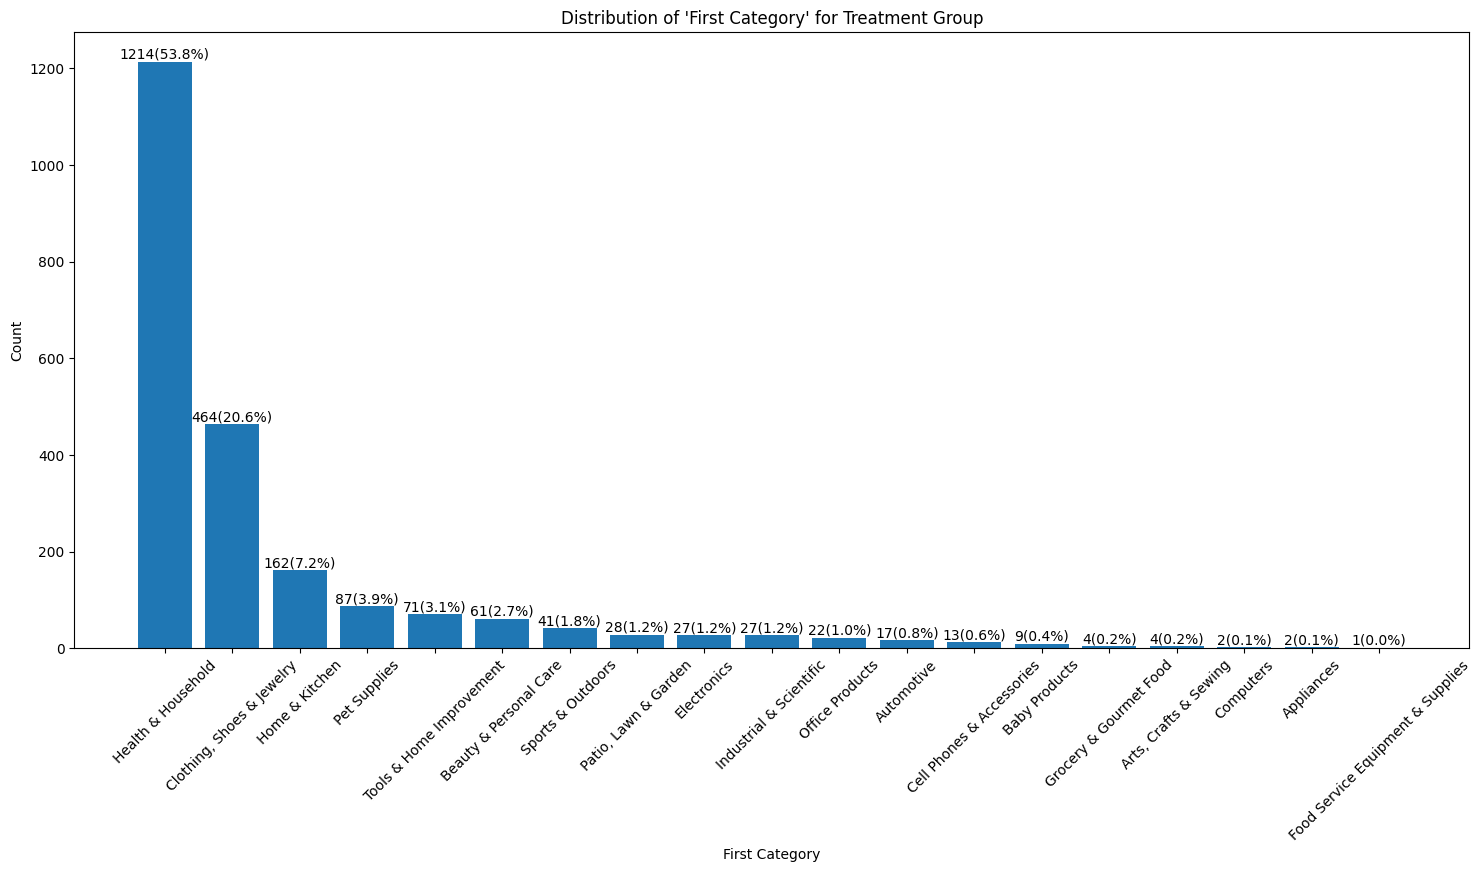

In [35]:
category_counts_treatment = Treatment_Group['first_category'].value_counts()
plt.figure(figsize = (18,8))
plt.bar(category_counts_treatment.index, category_counts_treatment)
plt.xlabel('First Category')
plt.ylabel('Count')
plt.title("Distribution of 'First Category' for Treatment Group")
plt.xticks(category_counts_treatment.index, rotation = 45)
for i, count in enumerate(category_counts_treatment):
    plt.text(i, count, f"{count}({count/sum(category_counts_treatment)*100 :.1f}%)", ha = 'center', va = 'bottom')

Based on the findings, we can observe that half of the products belong to the ``Health & Household``. Furthermore, when considering the combined percentage of products in the ``Health & Household``, ``Clothing, Shoes & Jewelry``, and ``Home & Kitchen`` categories, it exceeds 80%.

### 2.2 Control Group
- These products have never been advertised
- Sales revenue is not zero
- There products share the same first_category as the products in the Treatment_Group

In [36]:
url ='https://drive.google.com/file/d/114Ayx_dySir-a-Hivrsxra2uxNr7FPa3/view?usp=share_link'
file_id= url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'Treat_Group_info.csv'
gdown.download(url, file, quiet=False)
Control_Group = pd.read_csv(file).set_index('asin')
'''Control_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Control_Group.csv').set_index('asin')'''

Downloading...
From: https://drive.google.com/uc?id=114Ayx_dySir-a-Hivrsxra2uxNr7FPa3
To: /Users/haroldisthebest/Desktop/Treat_Group_info.csv
100%|██████████| 4.62M/4.62M [00:00<00:00, 18.4MB/s]


"Control_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Control_Group.csv').set_index('asin')"

In [37]:
# Drop products are no longer available
Control_Group = Control_Group.dropna(subset = ['first_category'])

#### a. Overview of the Distribution of the First Category

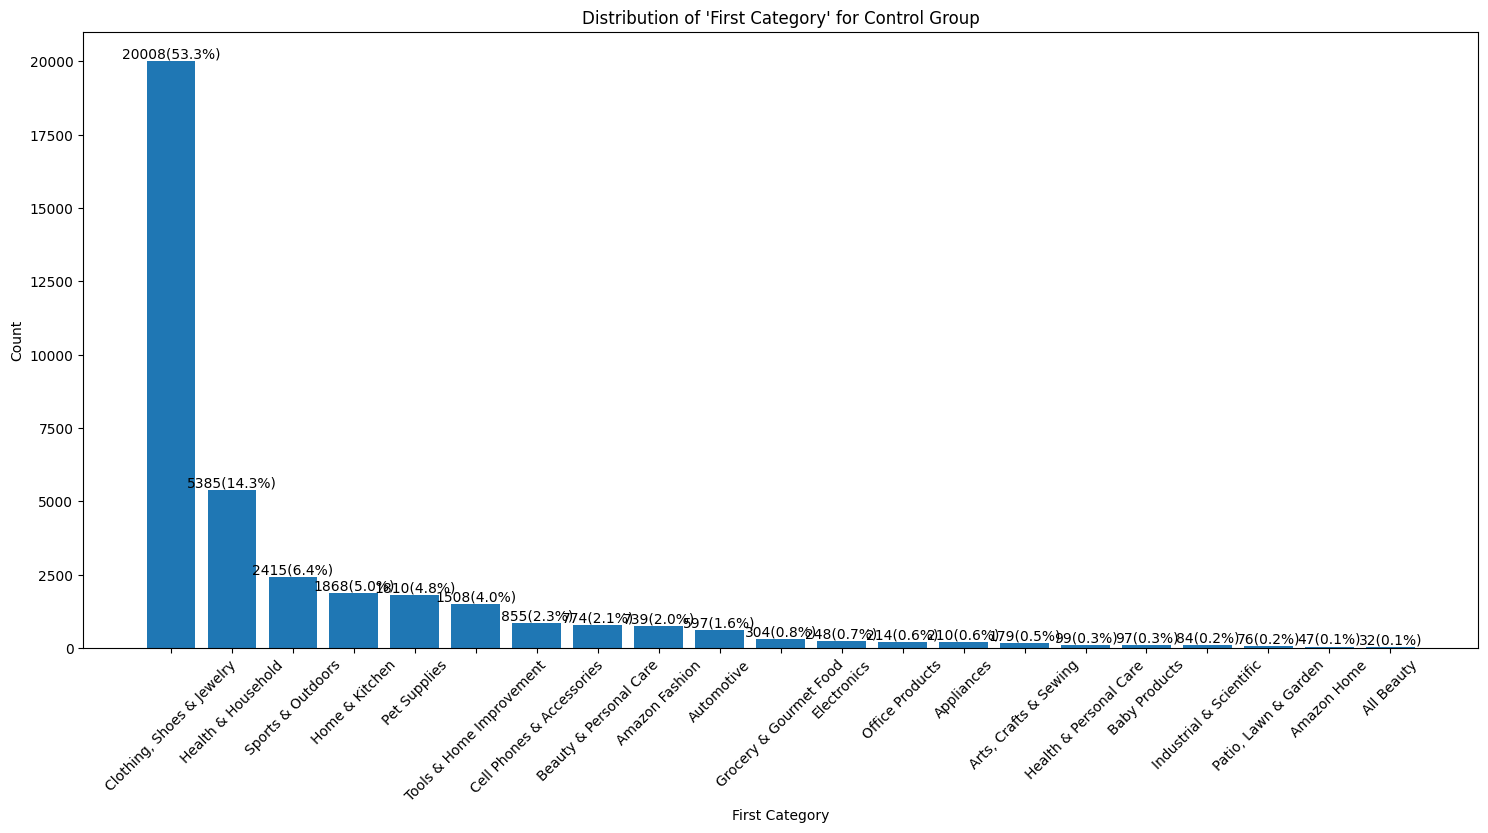

In [38]:
category_counts_control = Control_Group['first_category'].value_counts()
plt.figure(figsize = (18,8))
plt.bar(category_counts_control.index, category_counts_control)
plt.xlabel('First Category')
plt.ylabel('Count')
plt.title("Distribution of 'First Category' for Control Group")
plt.xticks(category_counts_control.index, rotation = 45)
for i, count in enumerate(category_counts_control):
    plt.text(i, count, f"{count}({count/sum(category_counts_control)*100 :.1f}%)", ha = 'center', va = 'bottom')

## 3 Matching

### 3.1 Preparation

In [39]:
num_features = ['average_units_noads', 'Price', 'rating', 'ratings']
dummy = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### a.Evaluate Matching Quality
Compare whether the distribution of matched samples converge on each feature (num_features)

In [40]:
def check_balance(matched_data, feature):
    
    matched_data = matched_data.dropna()
    
    Treatment_Group[['rating', 'ratings']] = Treatment_Group[['rating', 'ratings']].fillna(0)
    Control_Group[['rating', 'ratings']] = Control_Group[['rating', 'ratings']].fillna(0)
    Treat = Treatment_Group.loc[matched_data['treatment_asin']]
    Control = Control_Group.loc[matched_data['matched_asin']]
    Treat_features = Treat[feature]
    Control_features = Control[feature]
    
    plt.figure(figsize = (15, 6))
    sns.histplot(Treat_features, color = 'orange', label = 'Treatment', kde = True)
    sns.histplot(Control_features, color = 'blue', label = 'Control', kde = True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of {} After Matching'.format(feature))
    
    t_stat, p_value = ttest_ind(Treat_features, Control_features)
    print('T-Test Result - {}:'.format(feature))
    print('T-Statistic: {:.4f}'.format(float(t_stat)))
    print('P-Value: {:.4f}'.format(float(p_value)))
    
    if p_value > 0.05:
        print('The feature "{}" shows no significant difference after matching.'.format(feature))
    else:
        print('The feature "{}" shows a significant difference after matching.'.format(feature))
    print('')

#### b. Compare Matched Products' Sales Trend
Plot two matched products' sales trend

In [41]:
def plot_total_units(asin_treat, asin_control_psm, asin_control_similarity):
    
    plt.figure(figsize = (30, 8))
    if asin_treat != 'pass':
        t = Ads_agg.reset_index()
        t = t[t['asin'] == asin_treat]
        plt.plot(t.date, t.units_total, label='treat')
        plt.xticks(rotation = 60)
        plt.rcParams['xtick.labelsize'] = 6
        # mark the advertising time period
        ad_dates = t[t['ads'] == 1]['date'].values
        ad_dates = pd.to_datetime(ad_dates)
        for i in range(len(ad_dates) - 1):
            xmin = ad_dates[i].strftime("%Y-%m-%d")
            xmax = (ad_dates[i] + timedelta(days=1)).strftime("%Y-%m-%d")
            plt.axvspan(xmin=xmin, xmax=xmax, facecolor='gray', alpha=0.3)
        
    # mathed data
    if asin_control_psm != 'pass':
        c_psm = Sales[Sales['asin'] == asin_control_psm].sort_values(by='date')
        plt.plot(c_psm.date, c_psm.units_total, label='control_psm')

    if asin_control_similarity != 'pass':
        c_similarity = Sales[Sales['asin'] == asin_control_similarity].sort_values(by='date')
        plt.plot(c_similarity.date, c_similarity.units_total, label='control_similarity')

    plt.legend()
    plt.title('Total Units with Ad Annotation')
    plt.xlabel('Date')
    plt.ylabel('Total Units')
    plt.show()

#### c. Select Best Matched Product
Select the best match.

In [42]:
def calculate_cointegration(asin_treat, data):
    asin_control_psm = data[data['treatment_asin'] == asin_treat]['matched_asin_psm'].values[0]
    asin_control_similarity = data[data['treatment_asin'] == asin_treat]['matched_asin_similarity'].values[0]
    
    df_treat = Sales[Sales['asin'] == asin_treat].sort_values(by='date')[['date', 'units_total']]
    df_control_psm = Sales[Sales['asin'] == asin_control_psm].sort_values(by='date')[['date', 'units_total']]
    df_control_similarity = Sales[Sales['asin'] == asin_control_similarity].sort_values(by='date')[['date', 'units_total']]
    
    Compare = pd.merge(df_treat, df_control_psm, on = 'date', suffixes = ('', '_psm'))
    Compare = pd.merge(Compare, df_control_similarity, on = 'date', suffixes = ('', '_similarity'))
    Compare = pd.merge(Compare, Ads_agg.reset_index()[Ads_agg.reset_index()['asin'] == asin_treat][['date', 'ads']], on = 'date')
    result_psm = sm.tsa.stattools.coint(Compare.loc[Compare['ads'] == 0, 'units_total'], Compare.loc[Compare['ads'] == 0, 'units_total_psm'])
    result_similarity = sm.tsa.stattools.coint(Compare.loc[Compare['ads'] == 0, 'units_total'], Compare.loc[Compare['ads'] == 0, 'units_total_similarity'])
    if abs(result_psm[0]) > abs(result_similarity[0]):
        print('psm matching is better')
        return asin_control_psm, result_psm
    elif abs(result_psm[0]) < abs(result_similarity[0]):
        print('similarity matching is better')
        return asin_control_similarity, result_similarity
    else:
        print('same')
        return asin_control_psm, result_psm

### 3.2 Similarity: Calculate Manually

#### a. Preprocessing

In [43]:
Similarity_Data = pd.concat([Treatment_Group, Control_Group])
# Identify treatment / control
Similarity_Data['group'] = 0
Similarity_Data.loc[Treatment_Group.index, 'group'] = 1
# Fill NA in rating and ratings
Similarity_Data[['rating', 'ratings']] = Similarity_Data[['rating', 'ratings']].fillna(0)
# Transformation
    # BoxCox
for feature in num_features:
    transformed_data, lambda_ = stats.boxcox(Similarity_Data[feature] + 1)
    Similarity_Data[feature] = transformed_data
    # MinMax
scaler = MinMaxScaler()
Similarity_Data[num_features] = scaler.fit_transform(Similarity_Data[num_features])

#### b. Treatment / Control Split

In [44]:
treatment_candidates = Similarity_Data[Similarity_Data ['group'] == 1]
control_candidates = Similarity_Data[Similarity_Data ['group'] == 0]

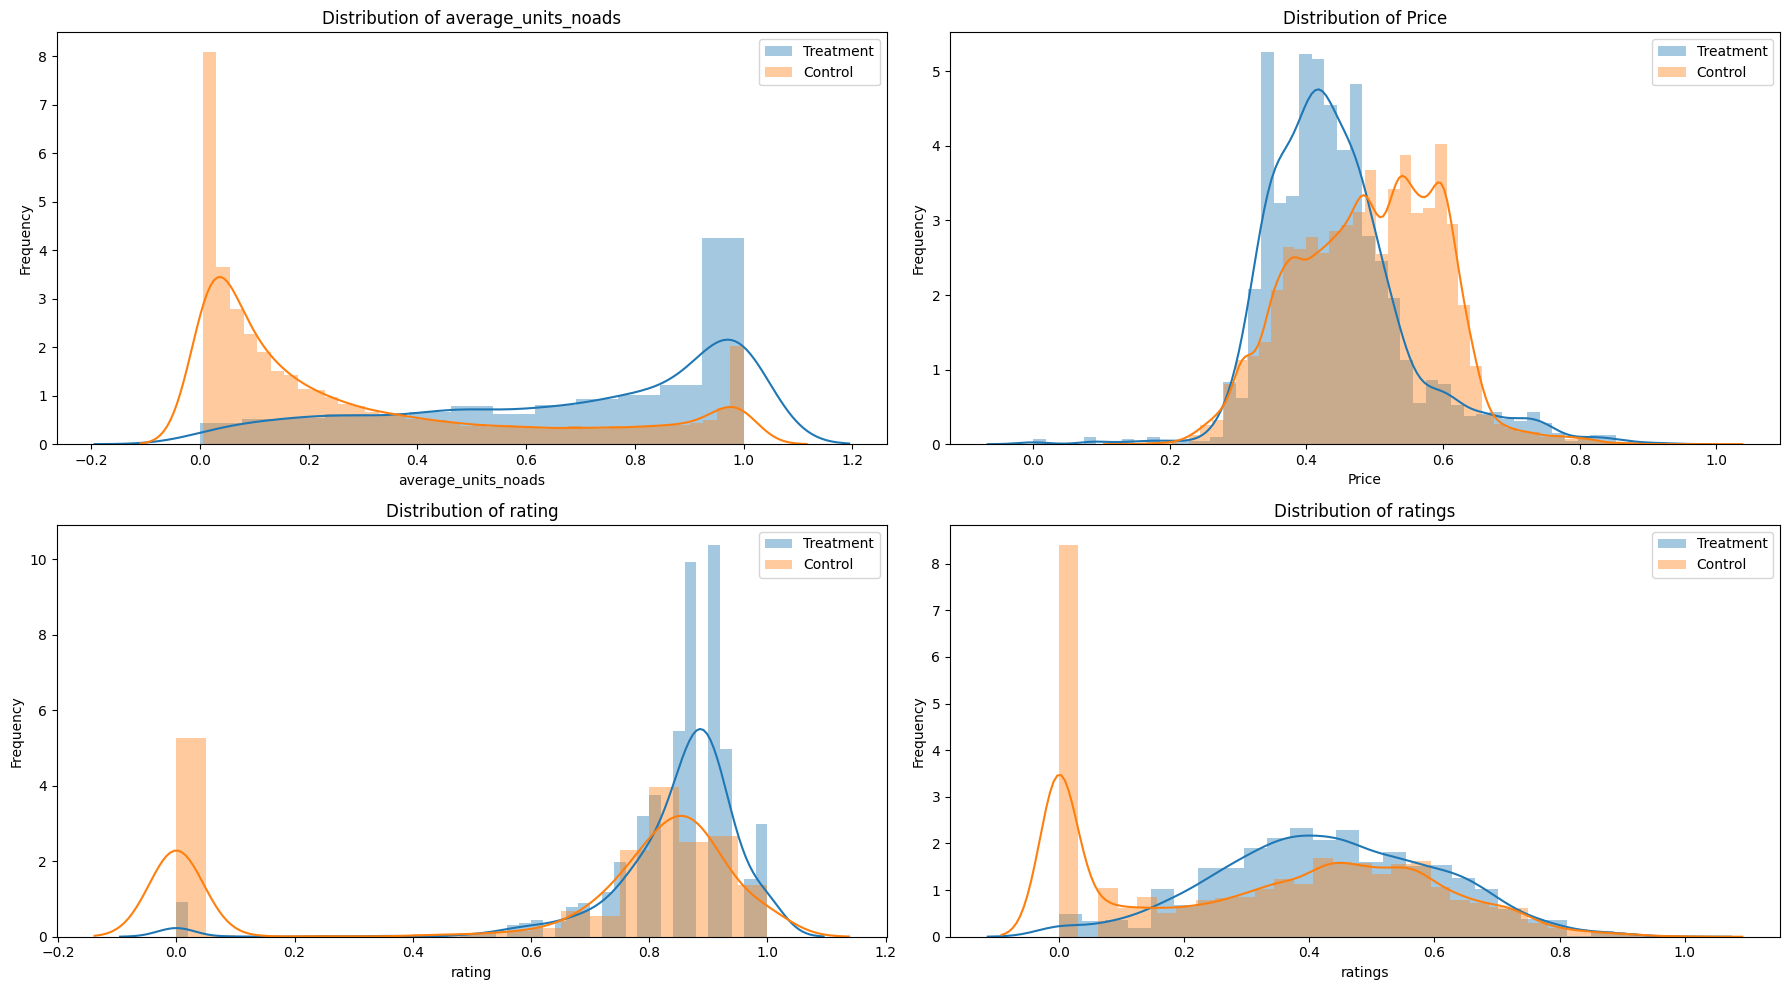

In [45]:
fig, axes = plt.subplots(2,2, figsize = (18,10))

for i, feature in enumerate(num_features):
    sns.distplot(treatment_candidates[feature], ax = axes[i//2, i%2], label = 'Treatment')
    sns.distplot(control_candidates[feature], ax = axes[i//2, i%2], label = 'Control')
    axes[i//2, i%2].set_xlabel(feature)
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].set_title(f'Distribution of {feature}')
    axes[i//2, i%2].legend()
plt.tight_layout()    

#### c. Calculate Similarity and Match Data
- num_features: Linalg
- dummy variables: Jaccard Similarity

=> Similarity

In [46]:
# Jaccard Similarity
def jaccard_similarity(set1, set2):
    set1 = set(set1)  
    set2 = set(set2) 
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [47]:
# 5 min
before = time.time()

matched_data_similarity = []

for _, t_row in treatment_candidates.iterrows():
    t_sample_num_features = t_row[num_features]
    t_sample_dum_features = t_row[dummy]
    t_sample_last_cat = t_row['last_category']
    t_sample_second_cat = t_row['second_category']
    t_sample_first_cat = t_row['first_category']
    
    min_similarity = np.inf
    best_match_index = None
    
    # select control group candidates that have the same last_category as the t_sample
    control_last_cat = control_candidates[control_candidates['last_category'] == t_sample_last_cat]
    if not control_last_cat.empty:
        for _, c_row in control_last_cat.iterrows():
            c_sample_num_features = c_row[num_features]
            c_sample_dum_features = c_row[dummy]
            
            similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
            similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
            similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
            
            if similarity < min_similarity:
                min_similarity = similarity
                best_match_index = c_row.name
                if similarity == 0:
                    break
                    
    if best_match_index is None:
        # select control group candidates that have the same second_category as the t_sample
        control_second_cat = control_candidates[control_candidates['second_category'] == t_sample_second_cat]
        if not control_second_cat.empty:
            for _, c_row in control_second_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    if best_match_index is None:
        # select control group candidates that have the same first_category as the t_sample
        control_first_cat = control_candidates[control_candidates['first_category'] == t_sample_first_cat]
        if not control_first_cat.empty:
            for _, c_row in control_first_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    matched_data_similarity.append((t_row.name, best_match_index))
        
after = time.time()
time_used = after - before
print("Execution time:", time_used, "seconds")

Execution time: 213.34123706817627 seconds


In [48]:
matched_data_similarity = pd.DataFrame(matched_data_similarity, columns=['treatment_asin', 'matched_asin'])
matched_data_similarity

,treatment_asin,matched_asin
0,B00014TQ5A,B073YL2LTR
1,B08HPKVJXG,B005JN0ZLC
2,B09CG7C8D4,B008M2T9GY
3,B09PC3TTK3,B09G8HYMQL
4,B001683A34,B00CS4KGJ6
...,...,...
2251,B07RZFGK87,B07GJKRK57
2252,B08B73FRCY,B01ISF0MLA
2253,B09PC4ZVBJ,B0B836X948
2254,B0BJ41DWKF,B0016A940U


In [49]:
# We don't have these categoris in the Control_Group
# Company; Food Service Equipment & Supplies
matched_data_similarity[matched_data_similarity.matched_asin.isnull()]

,treatment_asin,matched_asin
57,B07G4M5JM4,None
336,B0123X81UC,None
484,B005CJKF7C,None


### 3.3 PSM: PSM Scroe + KNN

#### a.Method

##### Method1 : Logistic Regression

In [50]:
def PSM_logistic(X, y):
    # Grid search for selecting the best model parameters
    param_grid = {
        'C': np.logspace(-5, 2, num = 8), 
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    # Using Logistic Regression to calculate propensity scores
    logreg = LogisticRegression()
    grid_search = GridSearchCV(logreg, param_grid, cv = 5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # get propensity scores
    propensity_scores = best_model.predict_proba(X)[:, 1]
    return propensity_scores, best_model

##### Method2 : Support Vector Machines

In [51]:
def PSM_SVM(X, y):
    # Grid search for selecting the best model parameters
    param_grid = {
    'C': [i for i in range(10, 15, 1)],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]}
    
    # using Support Vector Machines Classifier to calculate propensity scores
    svm = SVC(probability=True)
    grid_search = GridSearchCV(svm, param_grid, cv = 5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    
    # calculate propensity scores
    propensity_scores = best_model.predict_proba(X)[:, 1]
    return propensity_scores, best_model

##### Method3 : RandomForest Classifier

In [52]:
def PSM_RF(X, y):
    # Grid search for selecting the best model parameters
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'ccp_alpha': [0.0, 0.1, 0.2]  
    }
    
    # using Random Forest Classifier to calculate propensity scores
    rf = RandomForestClassifier(random_state = 42)
    grid_search = GridSearchCV(rf, param_grid, cv = 5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    
    # calculate propensity scores
    propensity_scores = best_model.predict_proba(X)[:, 1]
    return propensity_scores, best_model

#### b. Calculate PSM Score and Match Data

In [53]:
def get_matched_data(first_category):

    temp1 = Treatment_Group[Treatment_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]
    temp2 = Control_Group[Control_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]

    PSM_Data = pd.concat([temp1, temp2])
    
    # Identify treatment / control
    PSM_Data['group'] = 0
    PSM_Data.loc[temp1.index, 'group'] = 1
    # Fill NA in rating and ratings
    PSM_Data[['rating', 'ratings']] = PSM_Data[['rating', 'ratings']].fillna(0)
    PSM_Data = PSM_Data.dropna()
    
    # Resample the data
    X = PSM_Data.drop(['group'], axis = 1)
    y = PSM_Data['group']
    numeric = X.select_dtypes(['float64', 'int64']).columns
    cat = X.select_dtypes(exclude = ['float64', 'int64']).columns
    cat_indices = [X.columns.get_loc(col) for col in cat]
    smote = SMOTENC(categorical_features = cat_indices)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Transformation
        # BoxCox
    for feature in numeric:
        transformed_data, lambda_ = stats.boxcox(X_resampled[feature] + 1)
        X_resampled[feature] = transformed_data
        # StandardScaler
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_resampled[numeric])
    X_scaled = pd.DataFrame(X_num_scaled, columns = numeric)
    
    # Get propensity scores ### changing method
    propensity_scores, best_model = PSM_logistic(X_scaled, y_resampled)
    PSM_Data = PSM_Data.assign(score = list(propensity_scores)[:len(PSM_Data)])
    
    
    # Perform matching: KNN
    matcher = NearestNeighbors(n_neighbors = 1)
    control_candidates = PSM_Data[PSM_Data['group'] == 0]
    treatment_candidates = PSM_Data[PSM_Data['group'] == 1]
    
    matched_data = pd.DataFrame(columns=['treatment_asin', 'treatment_second_category', 'treatment_last_category', 'matched_asin', 'matched_second_category', 'matched_last_category'])
    
    for score_idx, score in enumerate(list(treatment_candidates.score)):
        treatment_sample = treatment_candidates.iloc[score_idx]
        
        # select control group candidates that have the same last_category as the t_s
        control_candidates_second = control_candidates[control_candidates['second_category'] == treatment_sample['second_category']]
        if len(control_candidates_second) > 0:
            control_candidates_last = control_candidates_second[control_candidates_second['last_category'] == treatment_sample['last_category']]
            if len(control_candidates_last) > 0:
                matcher.fit(np.array(control_candidates_last['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_last.iloc[nearest_idx[0][0]]
            else: 
                # if there are no control samples with the same last_category, choose the one that is closest to the treatment sample(same second_category)
                matcher.fit(np.array(control_candidates_second['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_second.iloc[nearest_idx[0][0]]
        else:
            # if there are no control samples with the same second_category, choose the one that is closest to the treatment sample(same first_category)
            matcher.fit(np.array(control_candidates['score']).reshape(-1, 1))
            _, nearest_idx = matcher.kneighbors([[score]])
            nearest_control_data = control_candidates.iloc[nearest_idx[0][0]]
        
        matched_data = pd.concat([matched_data, pd.DataFrame({
            'treatment_asin': treatment_sample.name,
            'treatment_second_category': treatment_sample['second_category'],
            'treatment_last_category': treatment_sample['last_category'],
            'matched_asin': nearest_control_data.name,
            'matched_second_category': nearest_control_data['second_category'],
            'matched_last_category': nearest_control_data['last_category']
        }, index = [0])], ignore_index = True)
    
    return matched_data, best_model

##### Pre-trained Model1: Health & Household

Logistic

In [54]:
# Logistic
category = 'Health & Household'
matched_data_HH_lr, best_model_HH_lr = get_matched_data(category)
best_model_HH_lr

LogisticRegression(C=0.0001, solver='liblinear')

In [55]:
#with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HH_lr.pkl', 'wb') as f:
#    pickle.dump(matched_data_HH_lr, f)
#with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HH_lr.pkl', 'wb') as f:
#    pickle.dump(best_model_HH_lr, f)

T-Test Result - average_units_noads:
T-Statistic: 1.4614
P-Value: 0.1440
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 1.6374
P-Value: 0.1017
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 4.9631
P-Value: 0.0000
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 0.7495
P-Value: 0.4536
The feature "ratings" shows no significant difference after matching.



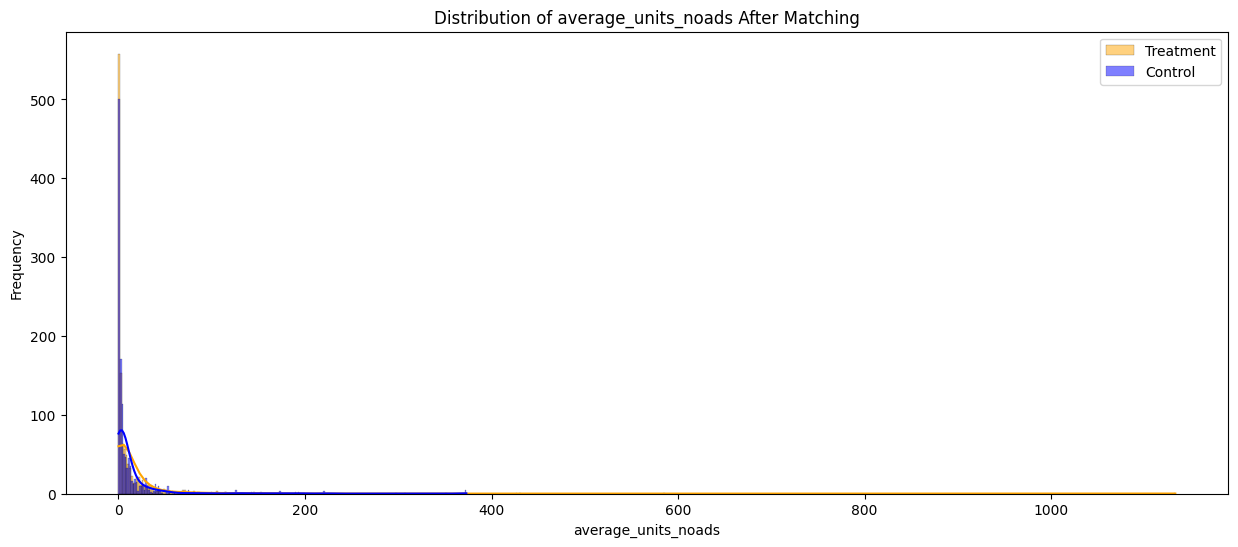

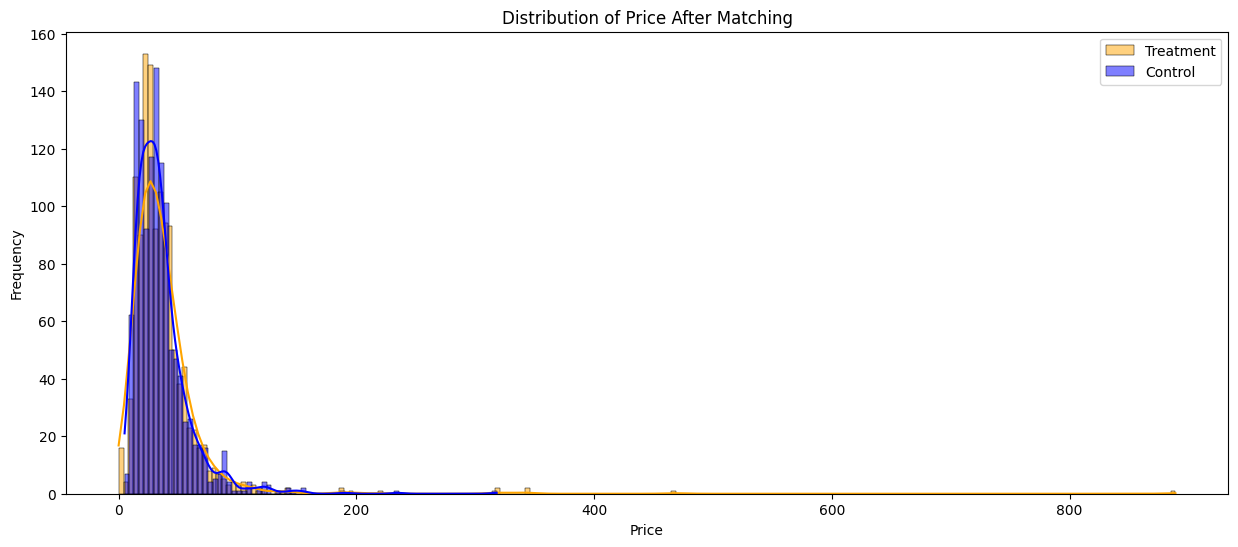

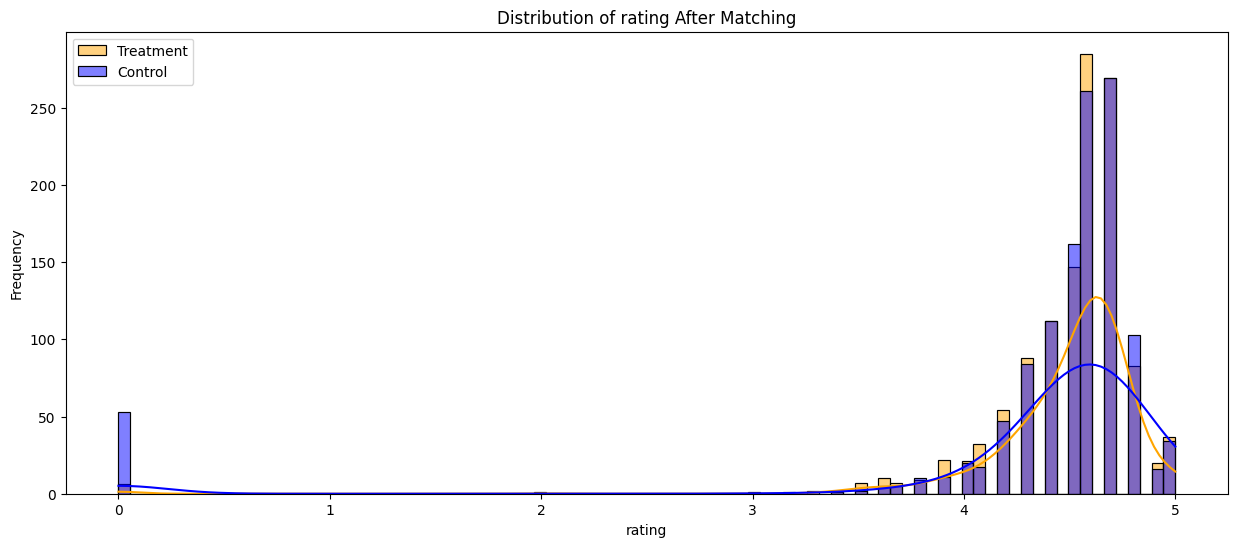

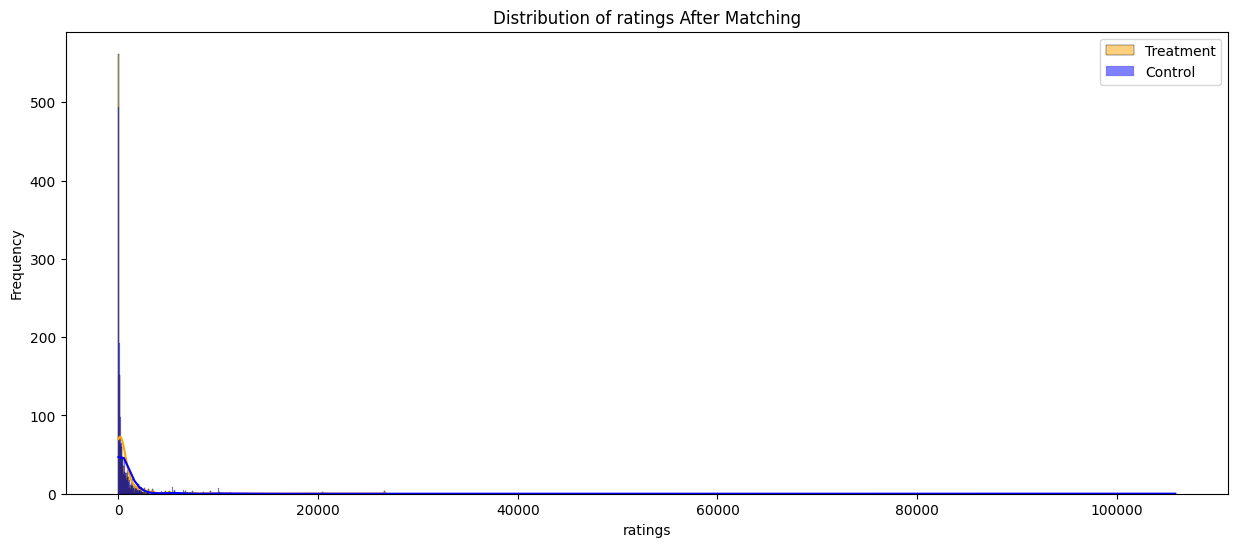

In [56]:
# Logistic
'''with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HH_lr.pkl', 'rb') as f:
    matched_data_HH_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HH_lr.pkl', 'rb') as f:
    best_model_HH_lr = pickle.load(f)'''
check_balance(matched_data_HH_lr, 'average_units_noads')
check_balance(matched_data_HH_lr, 'Price')
check_balance(matched_data_HH_lr, 'rating')
check_balance(matched_data_HH_lr, 'ratings')

SVM

In [57]:
# SVM
'''category = 'Health & Household'
matched_data_HH_svm, best_model_HH_svm = get_matched_data(category)
best_model_HH_svm'''

"category = 'Health & Household'\nmatched_data_HH_svm, best_model_HH_svm = get_matched_data(category)\nbest_model_HH_svm"

In [58]:
'''# SVM
check_balance(matched_data_HH_svm, 'average_units_noads')
check_balance(matched_data_HH_svm, 'Price')
check_balance(matched_data_HH_svm, 'rating')
check_balance(matched_data_HH_svm, 'ratings')'''

"# SVM\ncheck_balance(matched_data_HH_svm, 'average_units_noads')\ncheck_balance(matched_data_HH_svm, 'Price')\ncheck_balance(matched_data_HH_svm, 'rating')\ncheck_balance(matched_data_HH_svm, 'ratings')"

RF

In [59]:
'''# RF
category = 'Health & Household'
matched_data_HH_rf, best_model_HH_rf = get_matched_data(category)
best_model_HH_rf'''

"# RF\ncategory = 'Health & Household'\nmatched_data_HH_rf, best_model_HH_rf = get_matched_data(category)\nbest_model_HH_rf"

In [60]:
# RF
'''check_balance(matched_data_HH_rf, 'average_units_noads')
check_balance(matched_data_HH_rf, 'Price')
check_balance(matched_data_HH_rf, 'rating')
check_balance(matched_data_HH_rf, 'ratings')'''

"check_balance(matched_data_HH_rf, 'average_units_noads')\ncheck_balance(matched_data_HH_rf, 'Price')\ncheck_balance(matched_data_HH_rf, 'rating')\ncheck_balance(matched_data_HH_rf, 'ratings')"

##### Pre-trained Model2: Clothing, Shoes & Jewelry

Logistic

In [61]:
# Logistic
category = 'Clothing, Shoes & Jewelry'
matched_data_CSJ_lr, best_model_CSJ_lr = get_matched_data(category)
best_model_CSJ_lr

LogisticRegression(C=0.1, solver='liblinear')

In [62]:
#with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_CSJ_lr.pkl', 'wb') as f:
#    pickle.dump(matched_data_CSJ_lr, f)
#with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_CSJ_lr.pkl', 'wb') as f:
#    pickle.dump(best_model_CSJ_lr, f)

T-Test Result - average_units_noads:
T-Statistic: 1.5184
P-Value: 0.1293
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 0.8114
P-Value: 0.4173
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 0.2326
P-Value: 0.8162
The feature "rating" shows no significant difference after matching.

T-Test Result - ratings:
T-Statistic: -2.2024
P-Value: 0.0279
The feature "ratings" shows a significant difference after matching.



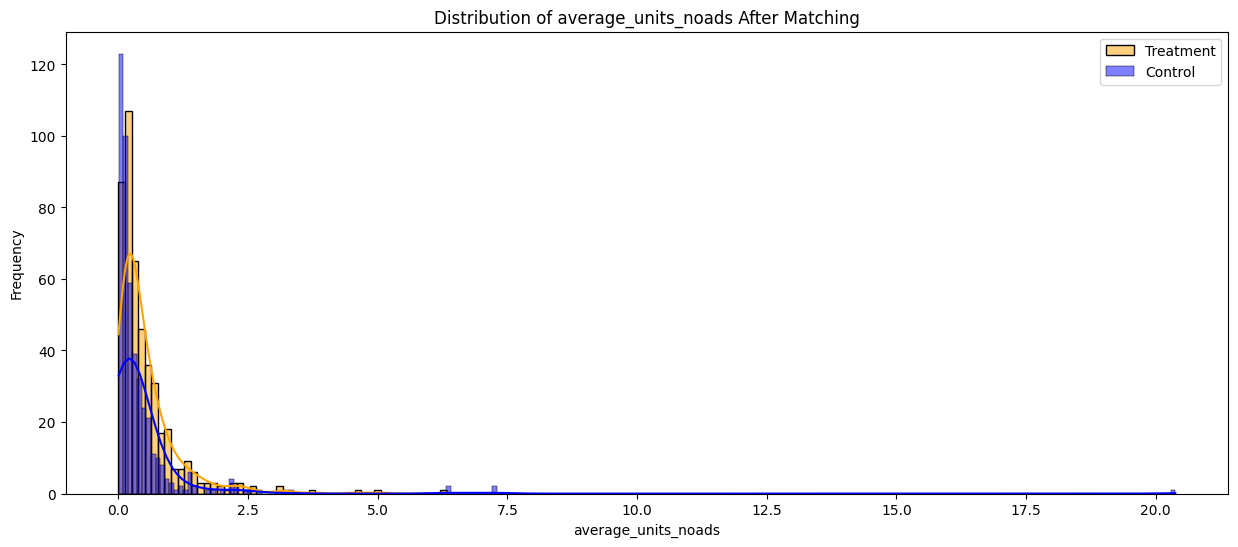

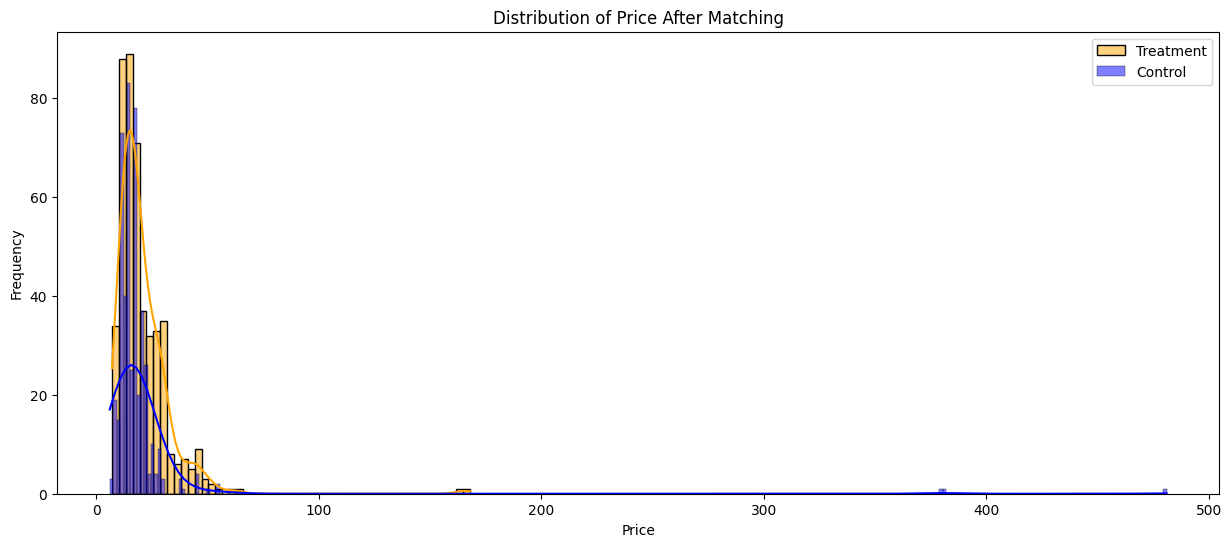

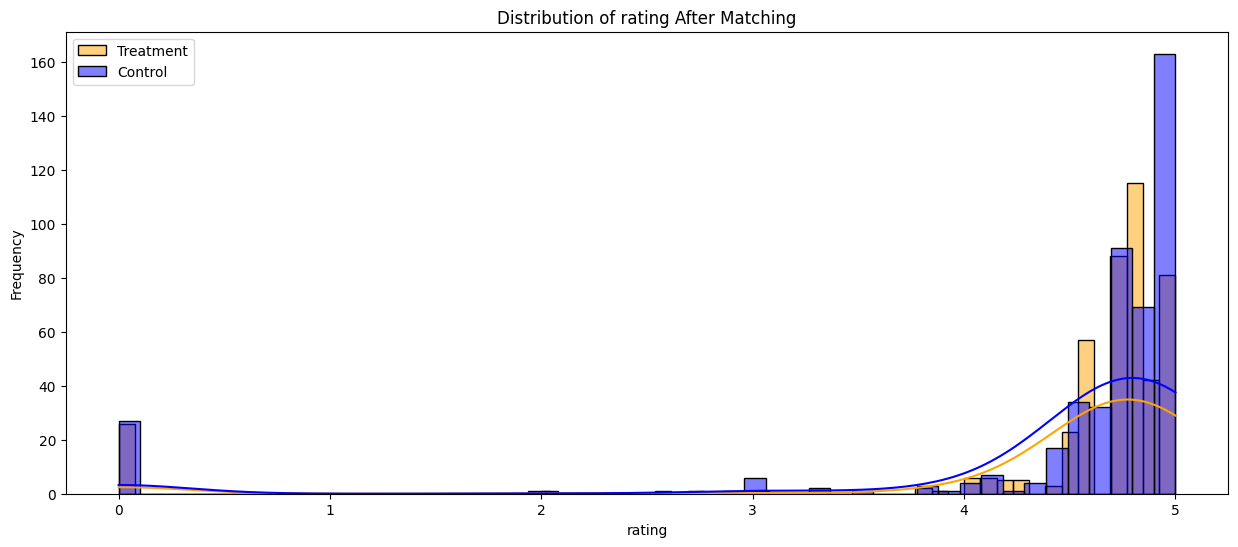

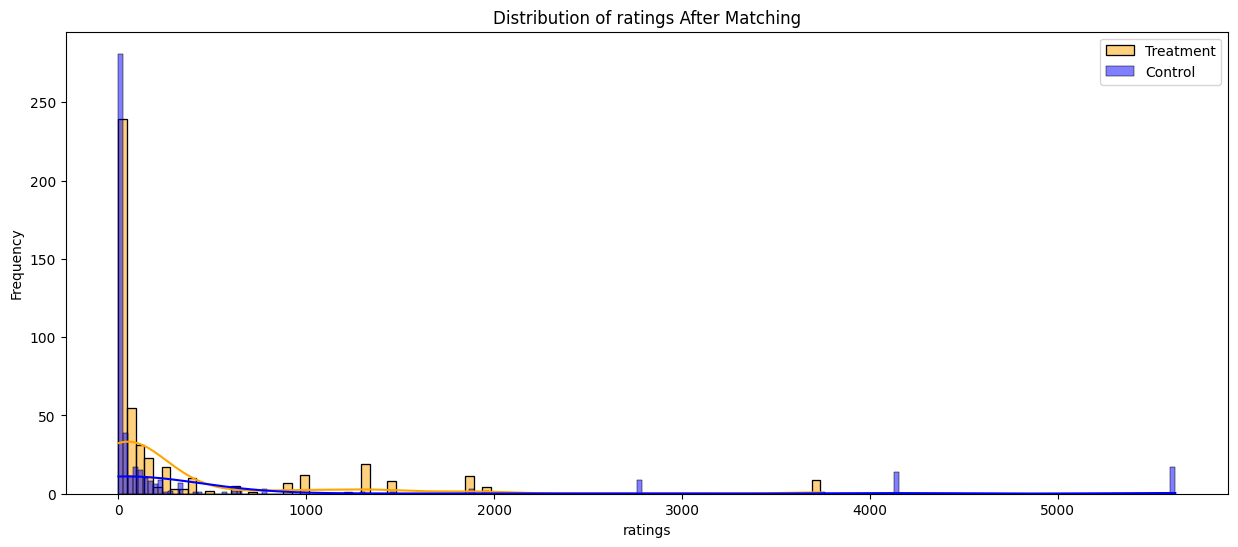

In [63]:
# Logistic
'''with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_CSJ_lr.pkl', 'rb') as f:
    matched_data_CSJ_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_CSJ_lr.pkl', 'rb') as f:
    best_model_CSJ_lr = pickle.load(f)'''
check_balance(matched_data_CSJ_lr, 'average_units_noads')
check_balance(matched_data_CSJ_lr, 'Price')
check_balance(matched_data_CSJ_lr, 'rating')
check_balance(matched_data_CSJ_lr, 'ratings')

SVM

In [64]:
'''# SVM
category = 'Clothing, Shoes & Jewelry'
matched_data_CSJ_svm, best_model_CSJ_svm = get_matched_data(category)
best_model_CSJ_svm'''

"# SVM\ncategory = 'Clothing, Shoes & Jewelry'\nmatched_data_CSJ_svm, best_model_CSJ_svm = get_matched_data(category)\nbest_model_CSJ_svm"

In [65]:
'''# SVM
check_balance(matched_data_CSJ_svm, 'average_units_noads')
check_balance(matched_data_CSJ_svm, 'Price')
check_balance(matched_data_CSJ_svm, 'rating')
check_balance(matched_data_CSJ_svm, 'ratings')'''

"# SVM\ncheck_balance(matched_data_CSJ_svm, 'average_units_noads')\ncheck_balance(matched_data_CSJ_svm, 'Price')\ncheck_balance(matched_data_CSJ_svm, 'rating')\ncheck_balance(matched_data_CSJ_svm, 'ratings')"

RF

In [66]:
'''# RF
category = 'Clothing, Shoes & Jewelry'
matched_data_CSJ_rf, best_model_CSJ_rf = get_matched_data(category)
best_model_CSJ_rf'''

"# RF\ncategory = 'Clothing, Shoes & Jewelry'\nmatched_data_CSJ_rf, best_model_CSJ_rf = get_matched_data(category)\nbest_model_CSJ_rf"

In [67]:
'''# RF
check_balance(matched_data_CSJ_rf, 'average_units_noads')
check_balance(matched_data_CSJ_rf, 'Price')
check_balance(matched_data_CSJ_rf, 'rating')
check_balance(matched_data_CSJ_rf, 'ratings')'''

"# RF\ncheck_balance(matched_data_CSJ_rf, 'average_units_noads')\ncheck_balance(matched_data_CSJ_rf, 'Price')\ncheck_balance(matched_data_CSJ_rf, 'rating')\ncheck_balance(matched_data_CSJ_rf, 'ratings')"

##### Pre-trained Model3: Home & Kitchen

Logistic

In [68]:
# Logistic
category = 'Home & Kitchen'
matched_data_HK_lr, best_model_HK_lr = get_matched_data(category)
best_model_HK_lr

LogisticRegression(penalty='l1', solver='liblinear')

In [69]:
#with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HK_lr.pkl', 'wb') as f:
#    pickle.dump(matched_data_HK_lr, f)
#with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HK_lr.pkl', 'wb') as f:
#    pickle.dump(best_model_HK_lr, f) 

T-Test Result - average_units_noads:
T-Statistic: -0.5817
P-Value: 0.5612
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: -2.3251
P-Value: 0.0207
The feature "Price" shows a significant difference after matching.

T-Test Result - rating:
T-Statistic: 2.6912
P-Value: 0.0075
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 0.1279
P-Value: 0.8983
The feature "ratings" shows no significant difference after matching.



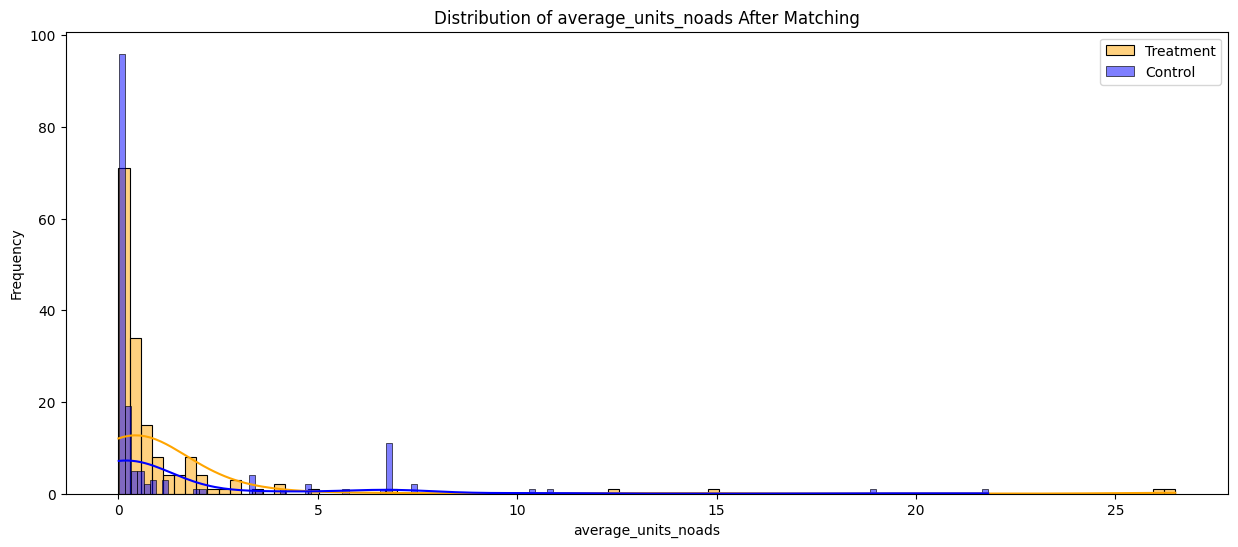

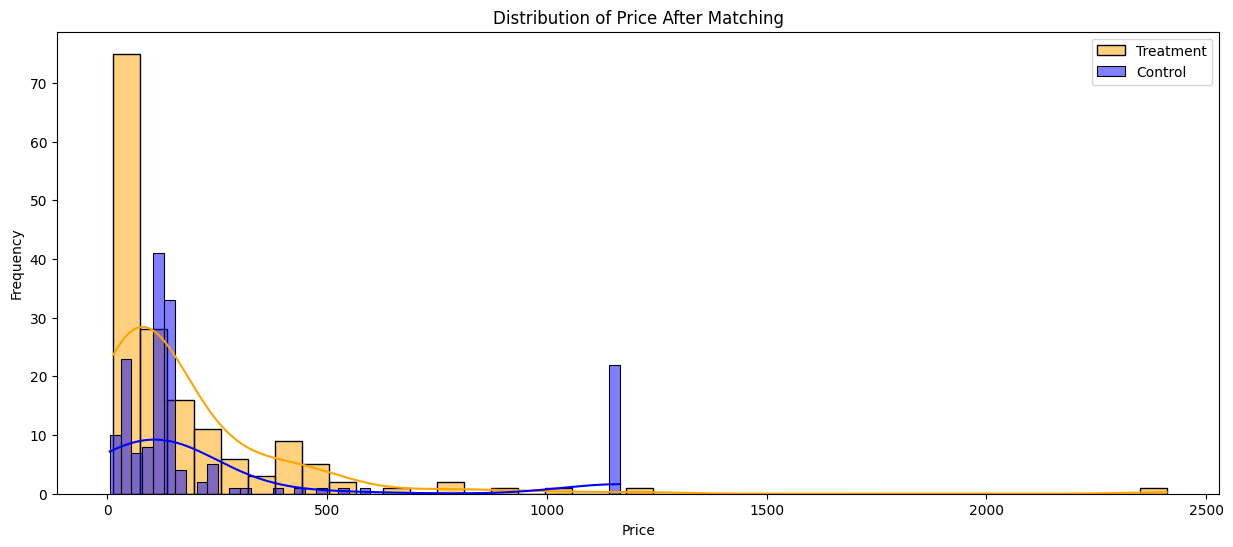

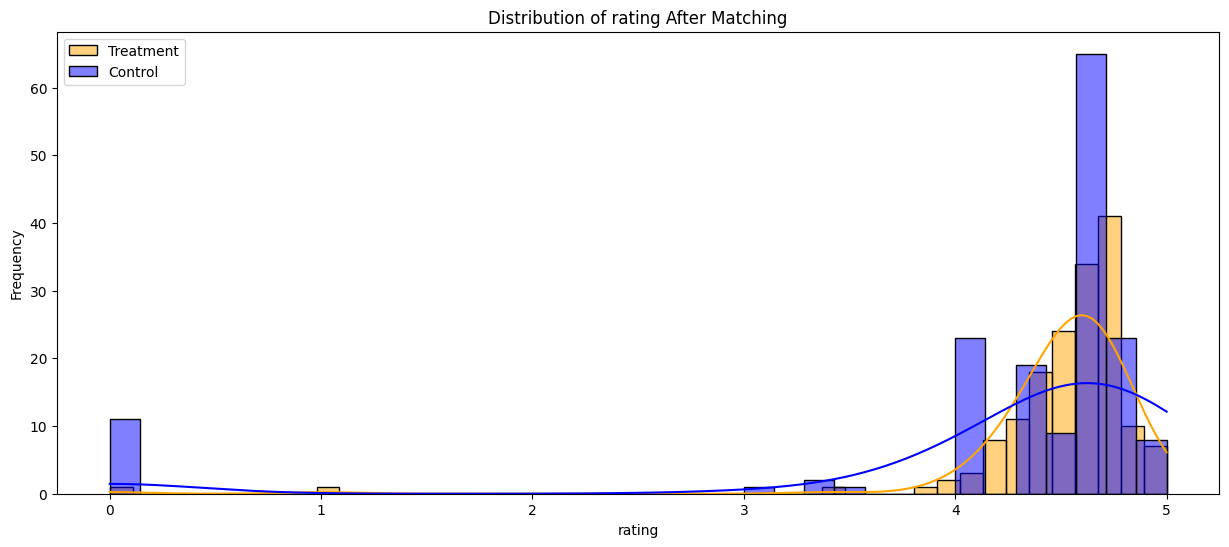

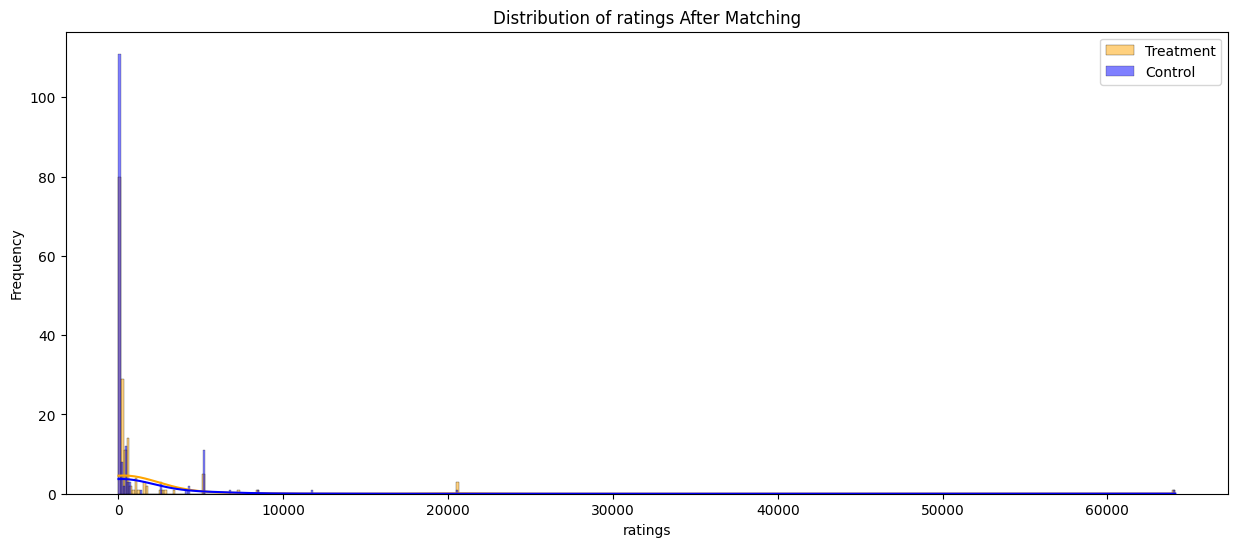

In [70]:
# Logistic
'''with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HK_lr.pkl', 'rb') as f:
    matched_data_HK_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HK_lr.pkl', 'rb') as f:
    best_model_HK_lr = pickle.load(f)'''
check_balance(matched_data_HK_lr, 'average_units_noads')
check_balance(matched_data_HK_lr, 'Price')
check_balance(matched_data_HK_lr, 'rating')
check_balance(matched_data_HK_lr, 'ratings')

SVM

In [71]:
'''# SVM
category = 'Home & Kitchen'
matched_data_HK_svm, best_model_HK_svm = get_matched_data(category)
best_model_HK_svm'''

"# SVM\ncategory = 'Home & Kitchen'\nmatched_data_HK_svm, best_model_HK_svm = get_matched_data(category)\nbest_model_HK_svm"

In [72]:
# SVM
'''
check_balance(matched_data_HK_svm, 'average_units_noads')
check_balance(matched_data_HK_svm, 'Price')
check_balance(matched_data_HK_svm, 'rating')
check_balance(matched_data_HK_svm, 'ratings')'''

"\ncheck_balance(matched_data_HK_svm, 'average_units_noads')\ncheck_balance(matched_data_HK_svm, 'Price')\ncheck_balance(matched_data_HK_svm, 'rating')\ncheck_balance(matched_data_HK_svm, 'ratings')"

RF

In [73]:
'''# RF
category = 'Home & Kitchen'
matched_data_HK_rf, best_model_HK_rf = get_matched_data(category)
best_model_HK_rf'''

"# RF\ncategory = 'Home & Kitchen'\nmatched_data_HK_rf, best_model_HK_rf = get_matched_data(category)\nbest_model_HK_rf"

In [74]:
# RF
'''check_balance(matched_data_HK_rf, 'average_units_noads')
check_balance(matched_data_HK_rf, 'Price')
check_balance(matched_data_HK_rf, 'rating')
check_balance(matched_data_HK_rf, 'ratings')'''

"check_balance(matched_data_HK_rf, 'average_units_noads')\ncheck_balance(matched_data_HK_rf, 'Price')\ncheck_balance(matched_data_HK_rf, 'rating')\ncheck_balance(matched_data_HK_rf, 'ratings')"

In [75]:
'''HK_C = pd.merge(matched_data_HK_lr[['treatment_asin', 'matched_asin']], 
                matched_data_HK_rf[['treatment_asin', 'matched_asin']],  
                on = 'treatment_asin', suffixes = ('', '_rf'))
HK_C = pd.merge(HK_C, 
                matched_data_HK_svm[['treatment_asin', 'matched_asin']],  
                on = 'treatment_asin', suffixes = ('', '_svm'))
HK_C['same_lr&rf'] = HK_C['matched_asin'] == HK_C['matched_asin_rf']
HK_C['same_lr&svm'] = HK_C['matched_asin'] == HK_C['matched_asin_svm']
HK_C['same_svm&rf'] = HK_C['matched_asin_svm'] == HK_C['matched_asin_rf']'''

"HK_C = pd.merge(matched_data_HK_lr[['treatment_asin', 'matched_asin']], \n                matched_data_HK_rf[['treatment_asin', 'matched_asin']],  \n                on = 'treatment_asin', suffixes = ('', '_rf'))\nHK_C = pd.merge(HK_C, \n                matched_data_HK_svm[['treatment_asin', 'matched_asin']],  \n                on = 'treatment_asin', suffixes = ('', '_svm'))\nHK_C['same_lr&rf'] = HK_C['matched_asin'] == HK_C['matched_asin_rf']\nHK_C['same_lr&svm'] = HK_C['matched_asin'] == HK_C['matched_asin_svm']\nHK_C['same_svm&rf'] = HK_C['matched_asin_svm'] == HK_C['matched_asin_rf']"

In [76]:
'''HK_C.loc[(HK_C['matched_asin'] == HK_C['matched_asin_rf']) & 
         (HK_C['matched_asin'] == HK_C['matched_asin_svm'])]'''

"HK_C.loc[(HK_C['matched_asin'] == HK_C['matched_asin_rf']) & \n         (HK_C['matched_asin'] == HK_C['matched_asin_svm'])]"

## 3.4 Compare and Select

In [77]:
HH = pd.merge(matched_data_similarity, matched_data_HH_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_similarity', '_psm'))
HH

,treatment_asin,matched_asin_similarity,matched_asin_psm
0,B00014TQ5A,B073YL2LTR,B073YL2LTR
1,B08HPKVJXG,B005JN0ZLC,B0006U6IEG
2,B001683A34,B00CS4KGJ6,B07WFQQQ41
3,B0797N816M,B0017050A2,B0017050A2
4,B07Q2M4634,B09RSMXHK7,B081YRWTDN
...,...,...,...
1209,B0036THMJY,B07GGFGXSQ,B07GGFGXSQ
1210,B01D8V075U,B00UZE9YZI,B00UZE9YZI
1211,B00CFTZ26G,B00EIZFAYE,B098KPQSMG
1212,B08B73FRCY,B01ISF0MLA,B08B7QJG3J


In [78]:
CSJ = pd.merge(matched_data_similarity, matched_data_CSJ_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_similarity', '_psm'))
CSJ.head()

,treatment_asin,matched_asin_similarity,matched_asin_psm
0,B09PC3TTK3,B09G8HYMQL,B08SQL5BVX
1,B09PC48WFK,B09PC3LDSH,B09PC3HXX8
2,B074QT8ZV3,B09N2DXNHF,B09PC43KX9
3,B00A17WCKI,B09N94G6KX,B0B49L28G9
4,B074QSW3NK,B0B31B1HW4,B07H3BS6C1


In [79]:
HK = pd.merge(matched_data_similarity, matched_data_HK_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_similarity', '_psm'))
HK

,treatment_asin,matched_asin_similarity,matched_asin_psm
0,B09CG7C8D4,B008M2T9GY,B0B8F2NCD3
1,B09CCF3LZ7,B07ZRVQJBJ,B008M2TA4K
2,B082GQ1V1Y,B085V63LQ8,B08CF3ST3C
3,B07N944D9J,B0033WTB3O,B0033WTB3O
4,B07HMSXMCB,B07HMVTBB1,B00M4JXK4I
...,...,...,...
157,B000GQACM4,B000VZCPMK,B001CFM460
158,B003TUANOG,B07D8CVKGH,B07L6SCNT9
159,B085L8WYG1,B07HMVTBB1,B0746VMGJ1
160,B07NQRY689,B0033WTB3O,B0033WTB3O


## 3.5 Interact: Test

### a. Ads Sensitivity Analysis

In [80]:
# 10 min ~
ads_sensitivity = {}
for asin in Ads_agg.index.get_level_values(0):
    if asin in SandA_Info[SandA_Info['A_actual'] == SandA_Info['S_delta']].index:
        continue
    group = Ads_agg.loc[asin]
    ad_sales = group[group.ads == 1]['units_total'].mean()
    noad_sales = group[group.ads == 0]['units_total'].mean()
    
    if noad_sales != 0:
        sensitivity =  (ad_sales - noad_sales) / noad_sales
    else: 
        sensitivity = - 100
    ads_sensitivity[asin] = sensitivity
ads_sensitivity = pd.DataFrame.from_dict(ads_sensitivity, orient = 'index').rename(columns={0: 'sensitivity'})

In [81]:
# NaN: sales records are later then the first ads record
ads_sensitivity[ads_sensitivity['sensitivity'].isna()]

,sensitivity
B01HD48OSU,NaN
B01HD48PAC,NaN
B09G9391NP,NaN
B09TWMJJVM,NaN
B0BJ4LR6MB,NaN
B0BMF8YH2P,NaN


In [82]:
ads_sensitivity_update = pd.merge(ads_sensitivity, Treatment_Group[['first_category', 'second_category', 'last_category']], left_index = True, right_index = True)
ads_sensitivity_update = pd.merge(ads_sensitivity_update, Ads[['asin', 'brand_id']].drop_duplicates(), left_index = True, right_on = 'asin')
# -100: no sales during no ads period 
# -1: no sales during ads period
ads_sensitivity_update = ads_sensitivity_update.set_index('asin')
ads_sensitivity_update.sort_values(by = 'sensitivity', ascending = False).head(20)

,sensitivity,first_category,second_category,last_category,brand_id
asin,,,,,
B00XBZFWJA,2748.111111,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B004O2I1Z6,241.649805,Beauty & Personal Care,Skin Care,Creams,44
B07V2BTRY1,207.374384,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B07VKPJTRG,127.620690,"Clothing, Shoes & Jewelry",Men,Socks,353
B09G8JWQJ4,121.823529,"Clothing, Shoes & Jewelry",Men,Active,353
B0BJ51SPLX,107.500000,Health & Household,Health Care,Essential Oil Singles,457
B00V6MUCL8,105.416185,Health & Household,"Vitamins, Minerals & Supplements",Magnesium,12
B00N9E4J3I,98.000000,"Clothing, Shoes & Jewelry",Luggage & Travel Gear,Travel Duffels,356
B0B7KMVT27,96.000000,Home & Kitchen,Furniture,Wine Cabinets,87


#### (i) Plot of Ads Sensitivity

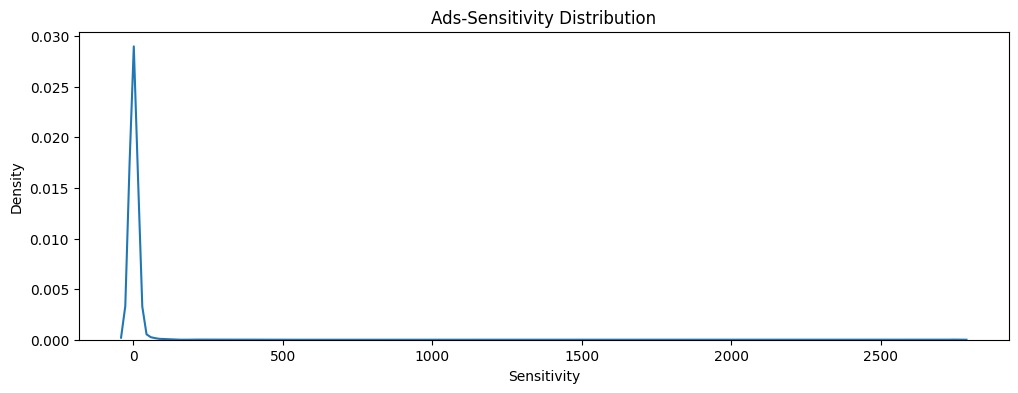

In [83]:
# Exclude records with sensitivity of -100, -1
temp = ads_sensitivity_update[~ads_sensitivity_update['sensitivity'].isin([-100, -1])].dropna()
plt.figure(figsize = (12, 4))
sns.kdeplot(temp['sensitivity'])
plt.xlabel('Sensitivity')
plt.ylabel('Density')
plt.title('Ads-Sensitivity Distribution')
plt.show()

#### (ii) Identify the 'outliers'
The ads effect of these products are significantly greater than effect of other products.

In [84]:
threshold = 3
temp = ads_sensitivity_update[~ads_sensitivity_update['sensitivity'].isin([-100, -1])].dropna()
temp = temp.reset_index()
outliers = temp.groupby(['first_category', 'second_category', 'last_category']).apply(lambda x: x[abs(stats.zscore(x['sensitivity'])) > threshold].sort_values(by='sensitivity', ascending=False)).reset_index(drop = True)
outliers.set_index(['first_category', 'second_category', 'last_category'])

asin  \
first_category            second_category                  last_category                                       
Clothing, Shoes & Jewelry Men                              Athletic Socks                         B07VM9W3TK   
                                                           Athletic Socks                         B08H53C9XD   
                                                           Athletic Socks                         B09G8HPVFX   
                                                           Athletic Socks                         B08R2MRGBL   
                                                           Athletic Socks                         B09PC3C2TQ   
                                                           Boxer Briefs                           B09PC4R4D4   
                                                           Liners & Ankle Socks                   B09G8KVV4S   
                                                           Socks                                  B07VKPJTRG   
                          Novelty & More                   Socks                                  B076Z87LZR   
                          Westlake                         Westlake                               B08ZT14873   
                          Women                            Athletic Socks                         B09L54NW12   
                                                           Socks                                  B09L532SDT   
Health & Household        Diet & Sports Nutrition          Detox & Cleanse                        B000FGZG3A   
                          Health Care                      Essential Oil Singles                  B0BJ51SPLX   
                          Vitamins, Minerals & Supplements Acetyl-L-Carnitine                     B00OA6NLG0   
                                                           Adrenal Extracts                       B00J8CEPXE   
                                                           B-Complex                              B000KYSCOM   
                                                           Blended Vitamin & Mineral Supplements  B08HSLQQPD   
                                                           Blended Vitamin & Mineral Supplements  B09BZSVGLV   
                                                           Blended Vitamin & Mineral Supplements  B003PR3OVW   
                                                           CoQ10                                  B01M6A97R0   
                                                           Iron                                   B0B6WRQVJ7   
                                                           Magnesium                              B00V6MUCL8   
                                                           Milk Thistle                           B000Z597EA   
                                                           Multivitamins                          B0929TCDDW   
                                                           Probiotics                             B012E7IV52   
                                                           Turmeric                               B006P8NAHQ   
                                                           Vitamin C                              B000MDY7RC   
                                                           Vitamin D                              B00EPQN6TW   
Home & Kitchen            Kitchen & Dining                 Countertop Blenders                    B00GPRPWAU   
Industrial & Scientific   Fasteners                        Framing Nails                          B002NU6HDY   
Pet Supplies              Dogs                             Multivitamins                          B00SLBELKK   
Tools & Home Improvement  Building Supplies                Ventilation Fans                       B00XBZFWJA   

                                                                                                  sensitivity  \
first_category            second_category                  last_catego

#### (iii) Plot of Ads Sensitivity by First_Category

In [85]:
# Not include outliers/ -100/ -1/ NaN
%matplotlib widget
category_sensitivity = {}
for category, sensitivity in temp[~temp.asin.isin(outliers.asin)].groupby('first_category')['sensitivity']:
    category_sensitivity[category] = sensitivity.values

current_category = 'Health & Household'

def plot_category(category):
    plt.gcf().clear()
    sns.histplot(category_sensitivity[category], bins=100, kde=True)
    plt.xlabel('Sensitivity')
    plt.ylabel('Frequency')
    plt.title(f'Category {category} Ads-Sensitivity Distribution')
    plt.show()

dropdown_category = widgets.Dropdown(
    options=ads_sensitivity_update['first_category'].unique(),
    value = current_category,
    description='Category:'
)
interactive_plot = widgets.interact(plot_category, category = dropdown_category)

display(dropdown_category)

interactive(children=(Dropdown(description='Category:', index=4, options=('Tools & Home Improvement', 'Industr…

Dropdown(description='Category:', index=4, options=('Tools & Home Improvement', 'Industrial & Scientific', 'Ho…

### b. Test

In [86]:
best_matched = None
def analyze_data(asin, data):
    global best_matched
    asin_treat = asin
    asin_control_psm = data[data['treatment_asin'] == asin_treat]['matched_asin_psm'].values[0]
    asin_control_similarity = data[data['treatment_asin'] == asin_treat]['matched_asin_similarity'].values[0]
    
    plot_total_units(asin_treat, asin_control_psm, asin_control_similarity)
    best_matched, result = calculate_cointegration(asin_treat, data)
    print('Best matching asin:', best_matched)
    print('Cointegration statistic:', result[0])
    print('p-value:', result[1])

Text(value='', description='ASIN:')

Dropdown(description='Category:', options=('HH', 'CSJ', 'HK'), value='HH')

Button(description='Analyze', style=ButtonStyle())

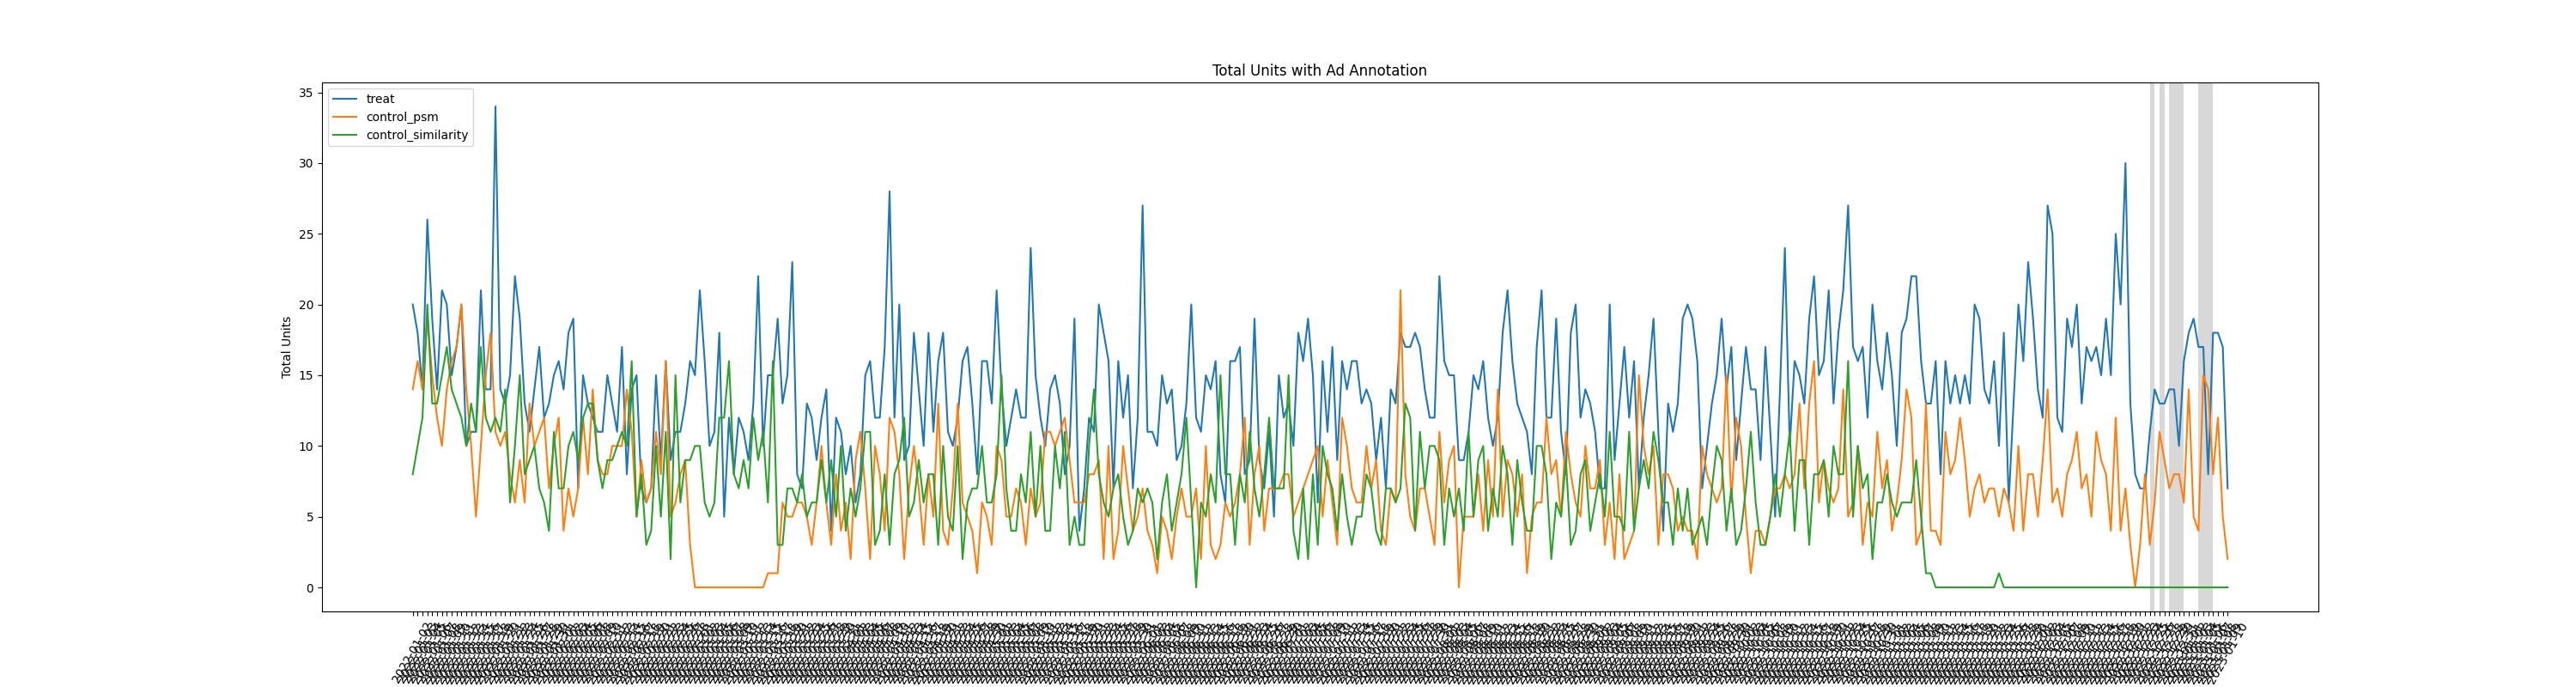

psm matching is better
Best matching asin: B0006U6IEG
Cointegration statistic: -16.32291936265319
p-value: 2.363280714712299e-28


In [87]:
asin_input = widgets.Text(description = 'ASIN:')
data_dropdown = widgets.Dropdown(options=['HH', 'CSJ', 'HK'], description = 'Category:')

def analyze_button_clicked(button):
    asin = asin_input.value
    data = data_dropdown.value
    
    if data == 'HH':
        analyze_data(asin, HH)
    elif data == 'CSJ':
        analyze_data(asin, CSJ)
    elif data == 'HK':
        analyze_data(asin, HK)

analyze_button = widgets.Button(description = 'Analyze')
analyze_button.on_click(analyze_button_clicked)

display(asin_input, data_dropdown, analyze_button)
#B08HPKVJXG

## 3.6 DID Model

In [88]:
asin_treat = asin_input.value

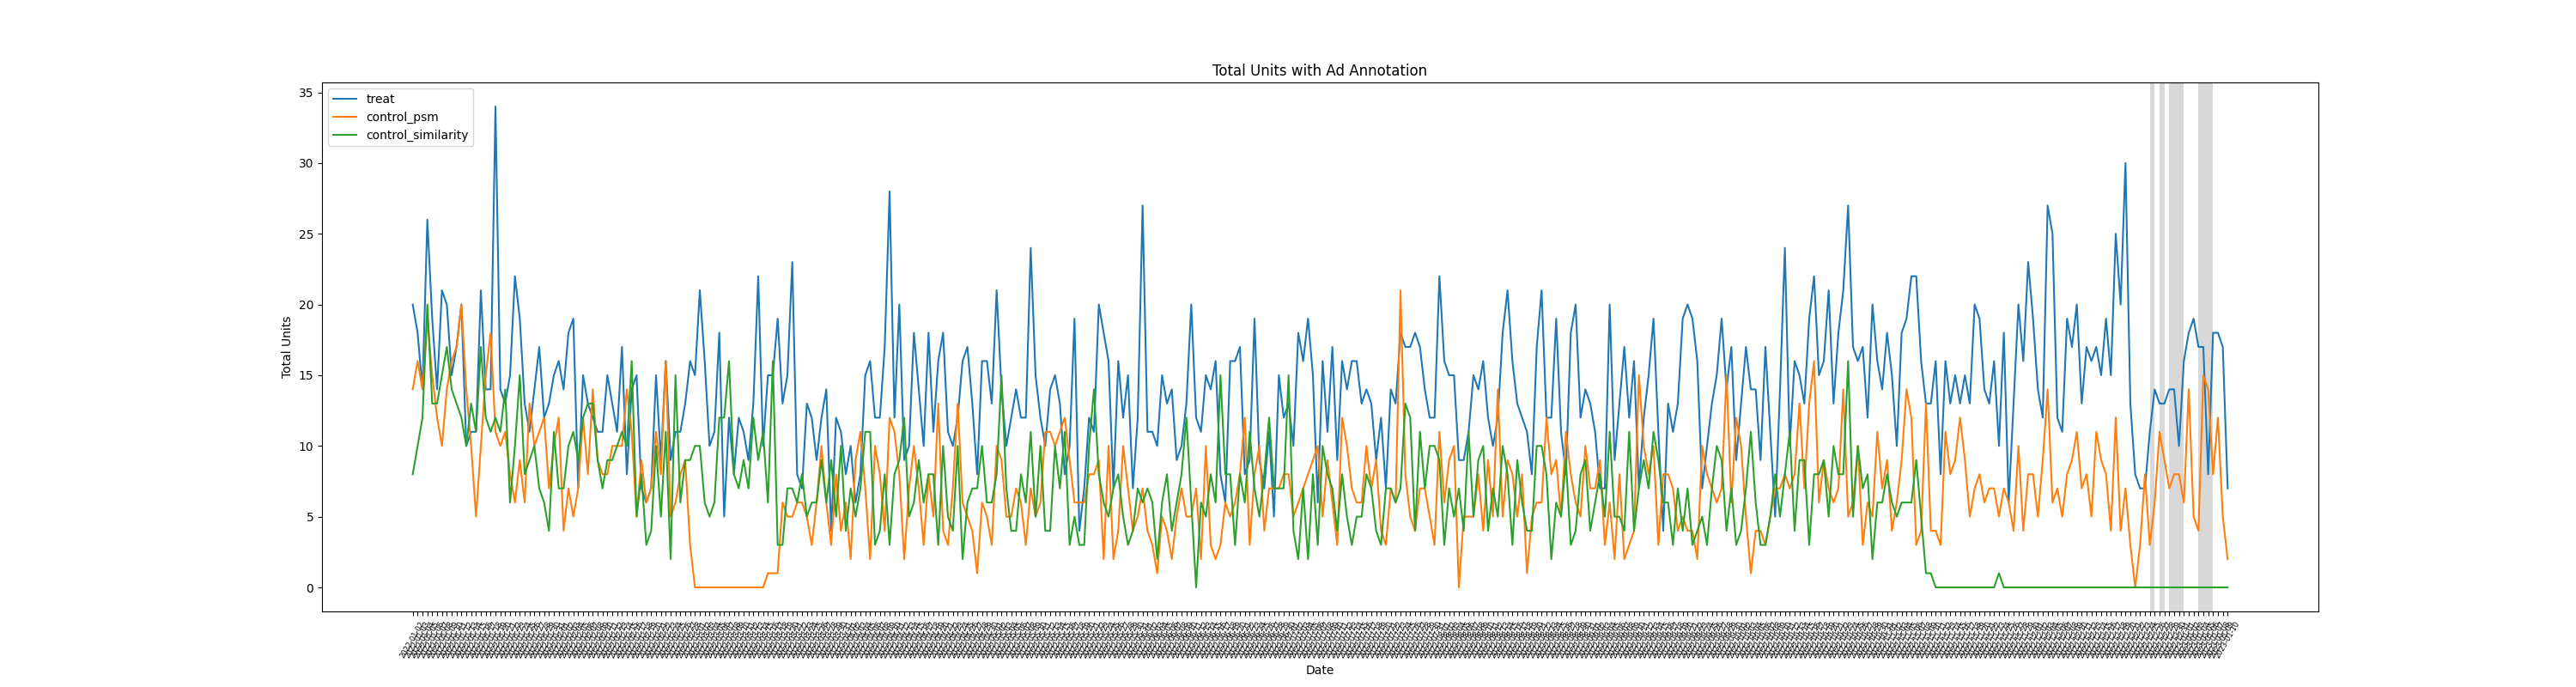

psm matching is better
Best matching asin: B0006U6IEG
Cointegration statistic: -16.32291936265319
p-value: 2.363280714712299e-28


In [89]:
analyze_data(asin_treat, HH)

In [90]:
DID_treat = Ads_agg.reset_index()[Ads_agg.reset_index().asin == asin_treat][['asin', 'date', 'units_total']]
DID_Control = Sales[Sales['asin'] == best_matched].sort_values(by='date')[['asin', 'date', 'units_total']]

DID_treat_subset = DID_treat[DID_treat['date'].isin(DID_Control['date'])]
DID_Control_subset = DID_Control[DID_Control['date'].isin(DID_treat['date'])]

DID = pd.concat([DID_treat_subset, DID_Control_subset], axis = 0)
DID['treat'] = (DID['asin'] == asin_treat).astype(int)
DID = pd.merge(DID, Ads_agg.reset_index()[Ads_agg.reset_index().asin == asin_treat][['date', 'ads']], on = 'date')

In [91]:
model = smf.ols(formula = 'units_total ~ treat*ads', data = DID).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     174.5
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           1.23e-85
Time:                        16:51:55   Log-Likelihood:                -2135.0
No. Observations:                 748   AIC:                             4278.
Df Residuals:                     744   BIC:                             4296.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0740      0.220     32.084      0.000       6.641       7.507
treat          7.0904      0.312     22.739      0.000       6.478       7.703
ads            1.5927      1.421      1.121      0.263      -1.198       4.383
treat:ads     -2.2015      2.010     -1.095      0.274      -6.148       1.745
==============================================================================
Omnibus:                       45.383   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.849
Skew:                           0.521   Prob(JB):                     6.12e-14
Kurtosis:                       3.931   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
DID

,asin,date,units_total,treat,ads
0,B08HPKVJXG,2022-01-02,20,1,0
1,B0006U6IEG,2022-01-02,14,0,0
2,B08HPKVJXG,2022-01-03,18,1,0
3,B0006U6IEG,2022-01-03,16,0,0
4,B08HPKVJXG,2022-01-04,14,1,0
...,...,...,...,...,...
743,B0006U6IEG,2023-01-08,12,0,0
744,B08HPKVJXG,2023-01-09,17,1,0
745,B0006U6IEG,2023-01-09,5,0,0
746,B08HPKVJXG,2023-01-10,7,1,0


## Part IV 

### BreakPoint Determination

---
Assuming minimal changes in the rankings and other factors between the day before and the first day of advertising, we can use the sales figures without advertising to predict the sales on the first day of advertising and consider it as the organic sales for the product.

The difference between the total sales(units_total) on the first day of advertising and the sales attributed to the advertising(attr_units) represents the platform's perceived organic sales for the product.

By comparing these two values, we can assess the cannibalization effect.

In [ ]:
def get_segments(df, asin):
    filtered_df = df[df['asin'] == asin]
    filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.date
    
    segments = []
    current_segment = []
    current_ads_state = None
    total_days = 0
    
    for index, row in filtered_df.iterrows():
        if row['ads'] != current_ads_state:
            if current_segment:  # Not null
                end_date = row['date'] - timedelta(1)
                days = (end_date - current_segment[0]).days + 1
                segment_type = 'ads' if current_ads_state == 1 else 'no ads'
                current_segment.extend([end_date, segment_type, days])
                
                # Sales
                segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                            (filtered_df['date'] <= end_date)]['units_total'].sum()
                current_segment.append(segment_sales)
                
                segments.append(tuple(current_segment))
                total_days += days
            
            current_ads_state = row['ads']
            current_segment = [row['date']]
    
    # last segment
    if current_segment:
        end_date = filtered_df['date'].max()
        days = (end_date - current_segment[0]).days + 1
        segment_type = 'ads' if current_ads_state == 1 else 'no ads'
        current_segment.extend([end_date, segment_type, days])
        
        # Sales
        segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                    (filtered_df['date'] <= end_date)]['units_total'].sum()
        current_segment.append(segment_sales)
        
        segments.append(tuple(current_segment))
        total_days += days
    
    segments.sort(key = lambda x: str(x[0]))
    segments.append(('Total Days', total_days))
    
    columns = ['Start', 'End', 'Segment Type', 'Duration', 'Sales']
    df_segments = pd.DataFrame(segments, columns = columns)
    
    return df_segments

In [ ]:
asin = 'B08H53C9XD'

Ads_agg_copy = Ads_agg.copy()
Ads_agg_copy.reset_index(inplace=True)
Ads_agg_copy['date'] = pd.to_datetime(Ads_agg_copy['date']).dt.date

segment_asin = get_segments(Ads_agg_copy, asin)

# max duration segment for no ads
no_ads_segments = segment_asin[segment_asin['Segment Type'] == 'no ads']
if len(no_ads_segments) > 1:
    max_duration_segment_idx = no_ads_segments['Duration'].idxmax()
    next_segment = segment_asin.iloc[max_duration_segment_idx + 1] if max_duration_segment_idx + 1 < len(segment_asin) else None
else:
    next_segment = None

if next_segment is None:
    # then choose the second longest segment
    sorted_segments = no_ads_segments.sort_values(by='Duration', ascending=False)
    max_duration_segment = sorted_segments.iloc[-2] if len(sorted_segments) > 1 else None
else:
    max_duration_segment = segment_asin.iloc[max_duration_segment_idx]


In [ ]:
Ads_agg_period = Ads_agg_copy[(Ads_agg_copy['asin'] == asin) &
                              (Ads_agg_copy['date'] >= max_duration_segment['Start']) & 
                              (Ads_agg_copy['date'] <= next_segment['End'])]

In [ ]:
experiment_series = Ads_agg_period[['units_total','attr_units', 'date', 'ads']].set_index('date')
experiment_series_train = experiment_series[experiment_series['ads'] == 0]
experiment_series_test = experiment_series[experiment_series['ads'] == 1]

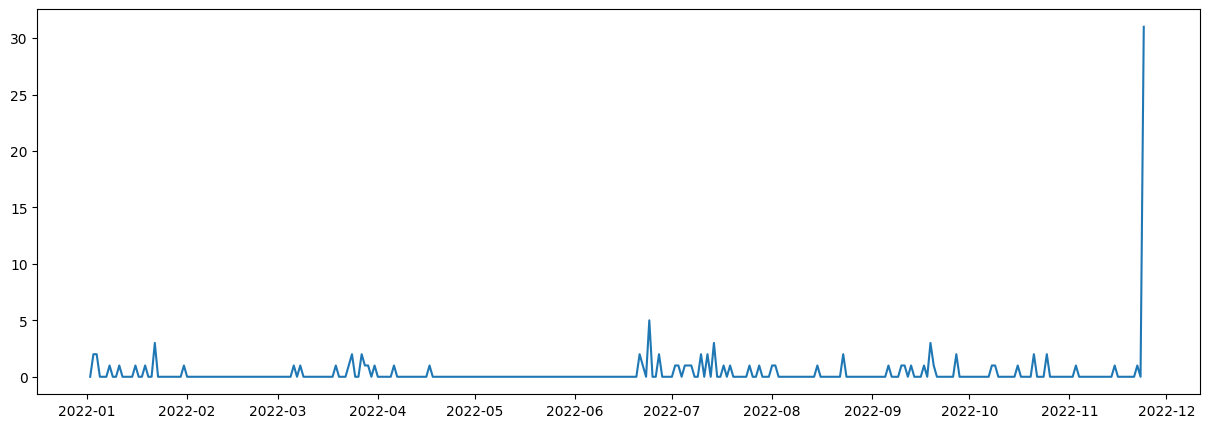

In [ ]:
%matplotlib inline
plt.figure(figsize = (15, 5))
plt.plot(experiment_series_train.index, experiment_series_train['units_total'], label = 'Ads')
plt.plot(experiment_series_test.index, experiment_series_test['units_total'], label = 'No Ads')
plt.show()

In [ ]:
def predict_sales_lstm(sales_data):
    train_size = int(0.8 * len(sales_data))
    train_data, val_data = sales_data[:train_size], sales_data[train_size:]
    k = math.ceil(len(val_data)*0.2)
    
    X_train, y_train = [], []
    for i in range(len(train_data) - k-1):
        X_train.append(train_data[i:i+k])
        y_train.append(train_data[i+k+1])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    X_val, y_val = [], []
    for i in range(len(val_data) - k-1):
        X_val.append(val_data[i:i+k])
        y_val.append(val_data[i+k+1]) 
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

    # LSTM Model
    model = Sequential()
    model.add(LSTM(32, input_shape=(k, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Callback
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0, validation_data=(X_val, y_val), callbacks=[checkpoint])

    # Load the saved model
    model.load_weights('best_model.h5')

    # Forecast
    input_data = np.reshape(val_data[-k:], (1, k, 1))  
    predicted_sales = model.predict(input_data)
    return predicted_sales[0][0]


In [ ]:
# Organic Sales predicted from the model
predict = predict_sales_lstm(experiment_series_train.units_total)
# Organic Sales provided by the Platform
diff = (experiment_series_test['units_total'] - experiment_series_test['attr_units']).iloc[0]
cannibalization = (predict - diff)/predict * 100
cannibalization

1/1 [==============================] - 0s 254ms/step


-8017.71642066071

In [ ]:
experiment_series_test

,units_total,attr_units,ads
date,,,
2022-11-25,22,4.0,1


In [ ]:
predict

0.22173724

In [ ]:
 Ads[(Ads['asin'] == asin) &
     (Ads['date'] == '2022-08-30')]

,country_code,brand_id,keyword,date,parent_asin,asin,overall_rank_organic,min_brand_rank,min_parent_rank,impressions,click,conversions,serp_scraped
3038278,US,3,acetyl cysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,73.0,32.0,2.0,1457.0,8.0,0.0,True
3038279,US,3,amino acids,2022-08-30,B0BHY684NR,B00OA6NLG0,NaN,NaN,2.0,843.0,8.0,1.0,True
3038280,US,3,n acetyl cysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,56.0,39.0,2.0,13226.0,124.0,34.0,True
3038281,US,3,n acetyl cysteine 600mg,2022-08-30,B0BHY684NR,B00OA6NLG0,17.0,11.0,2.0,918.0,11.0,2.0,True
3038282,US,3,n acetyl cysteine pure,2022-08-30,B0BHY684NR,B00OA6NLG0,NaN,NaN,2.0,14.0,2.0,1.0,False
3038283,US,3,n acetyl l cysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,107.0,74.0,2.0,133.0,11.0,5.0,True
3038284,US,3,n- acetylcysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,NaN,NaN,2.0,86.0,2.0,1.0,False
3038285,US,3,n-acetyl cysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,112.0,55.0,2.0,1642.0,25.0,8.0,True
3038286,US,3,n-acetyl cysteine supplement,2022-08-30,B0BHY684NR,B00OA6NLG0,NaN,NaN,2.0,7.0,1.0,0.0,False
3038287,US,3,n-acetylcysteine,2022-08-30,B0BHY684NR,B00OA6NLG0,83.0,34.0,2.0,331.0,13.0,3.0,True
